## Data extraction


In [1]:
%pip install printree

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import itertools
from cvxopt import matrix, solvers
from printree import ptree

url = "https://drive.google.com/file/d/12dUeEO_rkButPD79pOteFoSSeuIBg5qt/view?usp=drive_link"
file_id = url.split("/")[-2]
dwn_url = "https://drive.google.com/uc?id=" + file_id
dataset = pd.read_csv(dwn_url)

## Data analysis


In [3]:
dataset

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [4]:
TRAIN_TEST_SPLIT_PERCENTAGE = 0.9

# Split the data into train and test sets and shuffle
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset_training = dataset[: int(TRAIN_TEST_SPLIT_PERCENTAGE * len(dataset))]
dataset_test = dataset[int(TRAIN_TEST_SPLIT_PERCENTAGE * len(dataset)) :]

optim_params = {}
classification_results = {}
regression_results = {}

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import csv
%matplotlib inline

c:\Users\alepo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


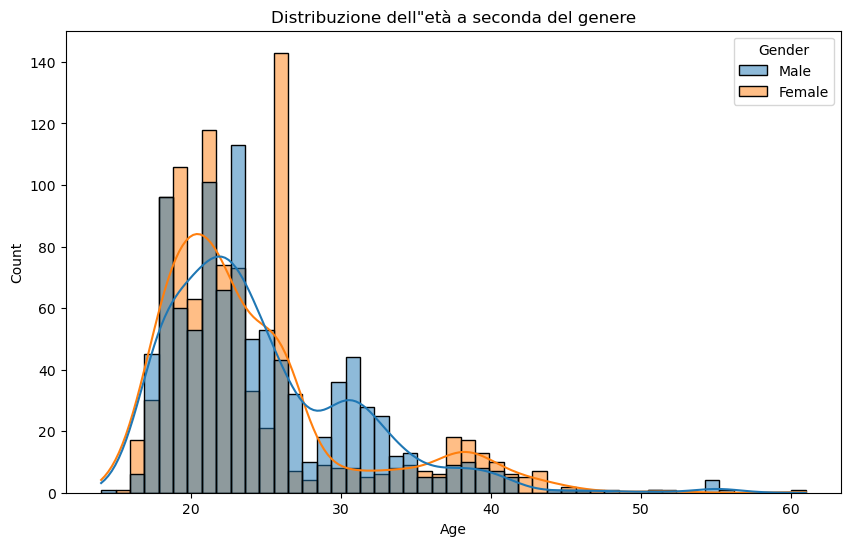

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(data=dataset_training, x="Age", kde=True, hue="Gender")
plt.title('Distribuzione dell"età a seconda del genere')
plt.show()

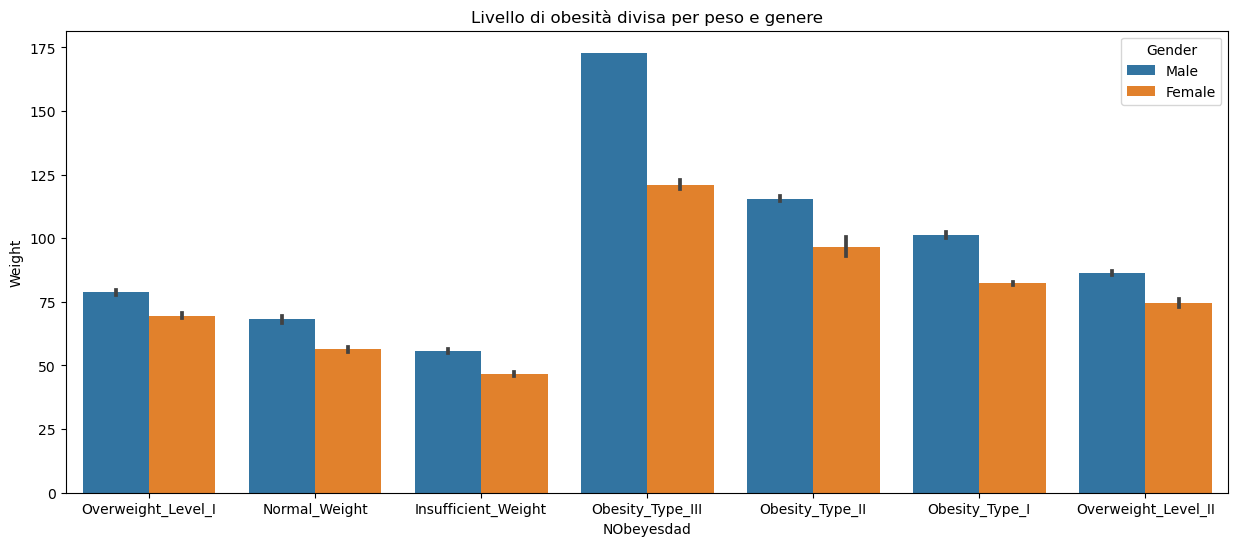

In [7]:
plt.figure(figsize=(15, 6))
sns.barplot(data=dataset_training, x="NObeyesdad", y="Weight", hue="Gender")
plt.title("Livello di obesità divisa per peso e genere")
plt.show()

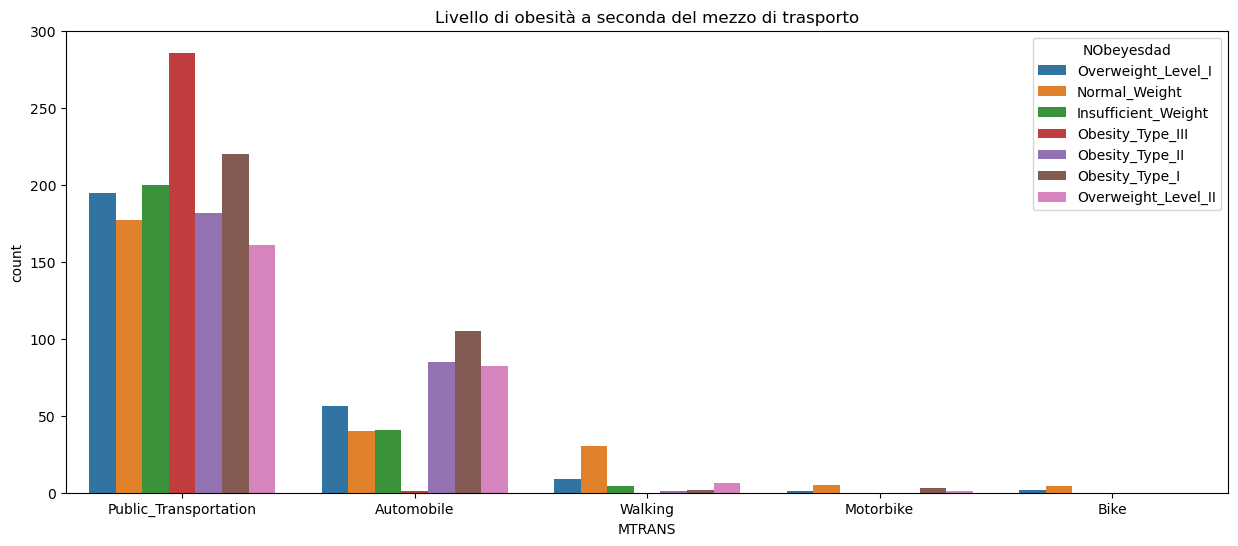

In [8]:
plt.figure(figsize=(15, 6))
sns.countplot(data=dataset_training, x="MTRANS", hue="NObeyesdad")
plt.title("Livello di obesità a seconda del mezzo di trasporto")
plt.show()

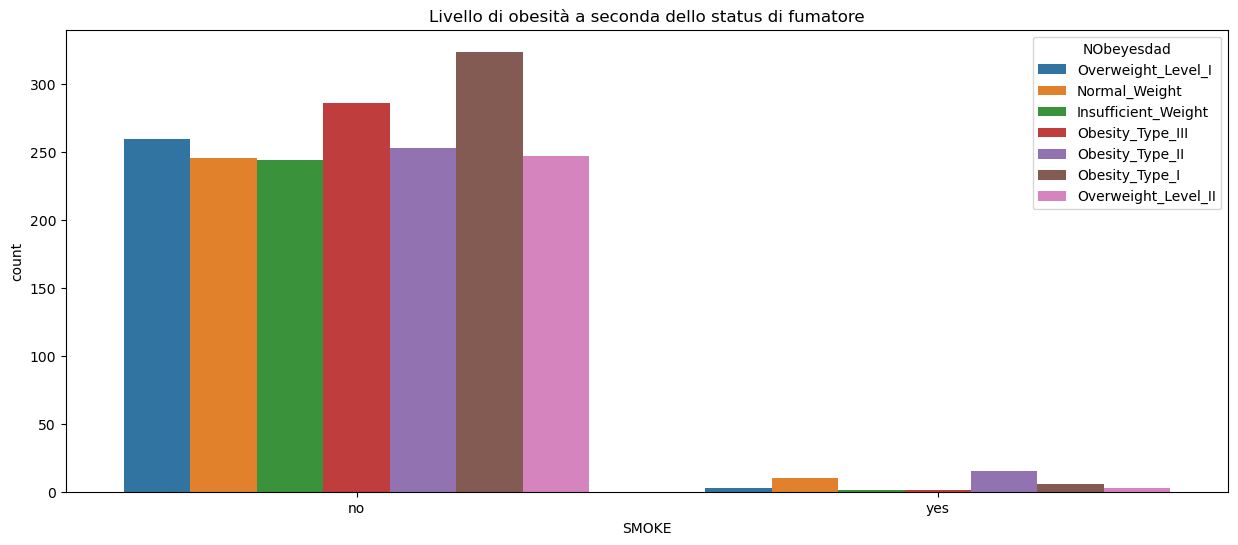

In [9]:
plt.figure(figsize=(15, 6))
sns.countplot(data=dataset_training, x="SMOKE", hue="NObeyesdad")
plt.title("Livello di obesità a seconda dello status di fumatore")
plt.show()

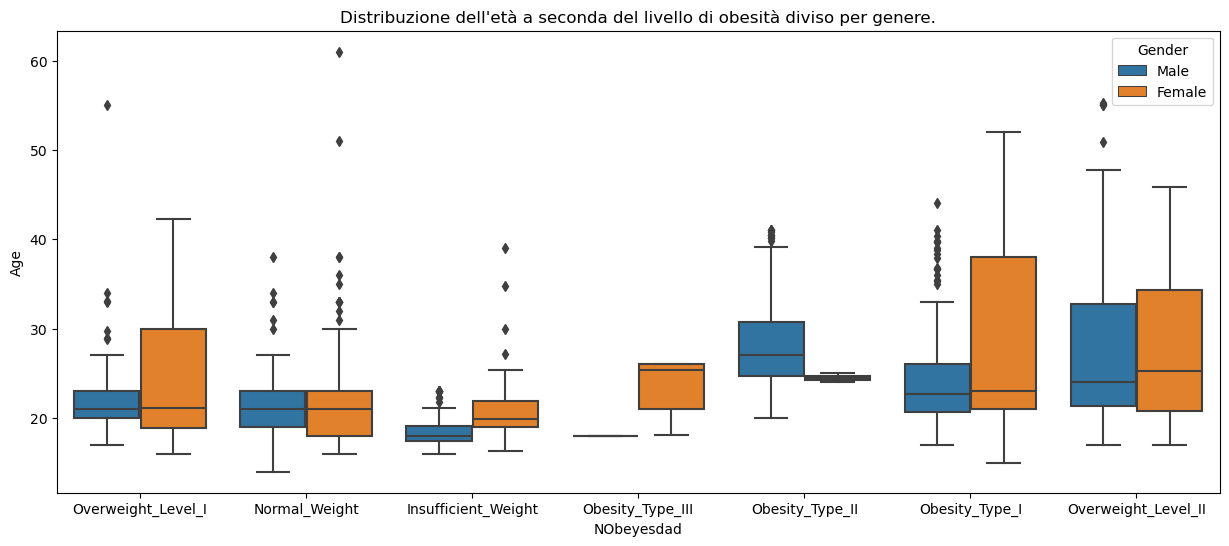

In [10]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=dataset_training, x="NObeyesdad", y="Age", hue="Gender")
plt.title("Distribuzione dell'età a seconda del livello di obesità diviso per genere.")
plt.show()

## Data preparation


### Implementazione dell'Encoder


L'Encoder prepara i dati per la classificazione / regressione. Dopo aver separato le colonne di X e y, implementa la possibilità di standardizzazione e discretizzazione. Per far in modo di effettuare la stessa standardizzazione e discrertizzazione sia per il training dataset che per il test dataset, durante il training vengono salvati i parametri necessari alla conversioni e semplicemente applicati durante il testing.


In [11]:
# Classe per la codifica dei dati

class Encoder:

    def __init__(self, mode, bins=-1, standardization=False):  # Inizializza la classe

        # Controlla che la modalità sia corretta
        assert mode in ["regression", "classification"]

        # Salva le variabili
        self.mode = mode
        self.bins = bins
        self.standardization = standardization
        self.bin_intervals = {}

    def encoding(self, data):  # Codifica i dati in modo che siano utilizzabili per l'addestramento

        # Copia i dati per non modificarli
        data = data.copy()

        # Mappatura delle colonne con valori categorici
        mappings = {
            "Gender": {"Male": 1, "Female": 0},
            "family_history_with_overweight": {"yes": 1, "no": 0},
            "FAVC": {"yes": 1, "no": 0},
            "SMOKE": {"yes": 1, "no": 0},
            "SCC": {"yes": 1, "no": 0},
            "CAEC": {"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3},
            "CALC": {"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3},
            "NObeyesdad": {
                "Insufficient_Weight": 0,
                "Normal_Weight": 1,
                "Overweight_Level_I": 2,
                "Overweight_Level_II": 3,
                "Obesity_Type_I": 4,
                "Obesity_Type_II": 5,
                "Obesity_Type_III": 6,
            },
        }

        # Mappa i valori
        for col, mapping in mappings.items():
            data[col] = data[col].map(mapping)

        # Codifica il mezzo di trasporto
        activity_types = [
            "Bike",
            "Walking",
            "Public_Transportation",
            "Motorbike",
            "Automobile",
        ]
        for activity in activity_types:
            data[activity] = (data["MTRANS"] == activity).astype(int)
        data = data.drop("MTRANS", axis=1)

        return data


    def standardize(self, X):  # Standardizza i dati e salva la media e la deviazione standard

        # Calcola la media e la deviazione standard
        self.mean = X.mean()
        self.std = X.std()

        # Applica la standardizzazione
        return self.apply_standardization(X)


    def apply_standardization(self, X):  # Applica la standardizzazione
        return (X - self.mean) / self.std

    def discretize(self, data, bins):  # Discretizza i dati in base al numero di bin e salva gli intervalli

        # Discretizza le colonne numeriche
        for col in data.columns:
            if len(data[col].unique()) > bins:

                # Calcola gli intervalli dei bin
                _, bin_edges = pd.cut(data[col], bins=bins, retbins=True, labels=False)

                # Salva gli intervalli dei bin nel dizionario
                self.bin_intervals[col] = bin_edges

                # Discretizza i dati
                data[col] = pd.cut(data[col], bins=bin_edges, labels=range(bins))

        return data

    def apply_discretization(self, data):  # Applica la discretizzazione
        data = data.copy()
        for col in self.bin_intervals.keys():

            # Limita i valori ai bin più estremi per evitare errori
            lower = (self.bin_intervals[col][0] + self.bin_intervals[col][1]) / 2
            upper = (self.bin_intervals[col][-1] + self.bin_intervals[col][-2]) / 2
            data[col] = np.clip(data[col], lower, upper)

            # Discretizza i dati
            data[col] = pd.cut(data[col], bins=self.bin_intervals[col], labels=range(self.bins))
        return data

    def regression(self, data):  # Prepara i dati per la regressione
        X = data.drop("Weight", axis=1)
        Y = data["Weight"]
        return X, Y

    def classification(self, data):  # Prepara i dati per la classificazione
        X = data.drop("NObeyesdad", axis=1)
        Y = (data["NObeyesdad"] > 3).astype(int)
        return X, Y

    def fit_transform(self, data):  # Applica tutte le trasformazioni ai dati

        # Codifica i dati
        data = self.encoding(data)

        # Prepara i dati per la regressione o la classificazione
        X, Y = (self.regression(data) if self.mode == "regression" else self.classification(data))

        # Standardizza i dati se si tratta di una regressione
        if self.standardization:
            X = self.standardize(X)

        # Discretizza i dati se è stato specificato un numero di bin
        if self.bins != -1:
            X = self.discretize(X, self.bins)
            Y = round(Y)

        return X.values, Y.values

    def transform(self, data):  # Applica le trasformazioni ai dati

        # Codifica i dati
        data = self.encoding(data)

        # Prepara i dati per la regressione o la classificazione
        X, Y = (self.regression(data) if self.mode == "regression" else self.classification(data))

        # Standardizza i dati se si tratta di una regressione
        if self.standardization:
            X = self.apply_standardization(X)

        # Discretizza i dati se è stato specificato un numero di bin
        if self.bins != -1:
            X = self.apply_discretization(X)

        return X.values, Y.values

### Metriche


In [12]:
# Funzioni per il calcolo delle metriche e la visualizzazione dei risultati

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 

def plot_confusion_matrix(y_pred, y, ax):  # Plotta la matrice di confusione
    cm = confusion_matrix(y_pred, y)
    ax.imshow(cm, cmap=plt.cm.Blues)
    ax.set_xticks(np.arange(2))
    ax.set_yticks(np.arange(2))
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title("Confusion Matrix")

def plot_roc_curve(y_pred, y, ax):  # Plotta la curva ROC
    fpr, tpr, _ = roc_curve(y, y_pred)
    ax.plot(fpr, tpr, marker=".")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")

def plot_precision_recall_curve(y_pred, y, ax):  # Plotta la curva Precision-Recall
    precision_scores, recall_scores, _ = precision_recall_curve(y, y_pred)
    ax.plot(recall_scores, precision_scores, marker=".")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve")

def plots(y_pred, y):  # Plotta la matrice di confusione, la curva ROC e la curva Precision-Recall
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    plot_confusion_matrix(y_pred, y, axs[0])
    plot_roc_curve(y_pred, y, axs[1])
    plot_precision_recall_curve(y_pred, y, axs[2])
    plt.tight_layout()
    plt.show()

def metrics(y_pred, y, mode):  # Calcola le metriche in base alla modalitàe ritorna un dizionario con le metriche
    if mode == "regression":
        print("MSE:", mean_squared_error(y_pred, y), "\nMAE:", mean_absolute_error(y_pred, y), "\nRMSE:", np.sqrt(mean_squared_error(y_pred, y)))
        return {"MSE": mean_squared_error(y_pred, y), "MAE": mean_absolute_error(y_pred, y), "RMSE": np.sqrt(mean_squared_error(y_pred, y))}
    else:
        print("Accuracy:", accuracy_score(y_pred, y), "\nPrecision:", precision_score(y_pred, y), "\nRecall:", recall_score(y_pred, y), "\nF1 Score:", f1_score(y_pred, y), "\nAUC:", roc_auc_score(y_pred, y))
        plots(y_pred, y)
        return {"Accuracy": accuracy_score(y_pred, y), "Precision": precision_score(y_pred, y), "Recall": recall_score(y_pred, y), "F1 Score": f1_score(y_pred, y), "\nAUC:": roc_auc_score(y_pred, y)}

### Scelta degli iperparametri


In [13]:
def cross_validation(model, x, y, k, loss):  # k-fold cross validation
    size = len(x) // k
    errors = []

    # Itera su ogni fold
    for i in range(k):

        # Divide il dataset in training e validation set
        x_train = np.concatenate((x[: i * size], x[(i + 1) * size :]), axis=0)
        y_train = np.concatenate((y[: i * size], y[(i + 1) * size :]), axis=0)
        x_val = x[i * size : (i + 1) * size]
        y_val = y[i * size : (i + 1) * size]

        # Addestra il modello e calcola l'errore
        model.fit(x_train, y_train)
        predictions = model.predict(x_val)
        error = loss(predictions, y_val)
        errors.append(error)

    # Restituisce l'errore medio
    return np.mean(errors)

def grid_search(x, y, model_class, model_params, k, loss, show_pregress):  # Grid search per la ricerca dei parametri ottimali

    # Generate all possible combinations of model parameters
    values = [model_params[param] for param in model_params]
    combinations = list(itertools.product(*values))
    errors = []

    # Se c'è solo una combinazione di parametri, restituisci quella
    if len(combinations) == 1:
        return combinations[0]

    # Itera su ogni combinazione di parametri
    for combo in combinations:

        # Calcola l'errore
        error = cross_validation(model_class(*combo), x, y, k, loss)

        # Salva l'errore
        errors.append(error)

        # Stampa il progresso
        if show_pregress:
            print(f"Combo: {combo}, Error: {error}")

    # Trova la combinazione di parametri con l'errore minore
    return combinations[np.argmin(errors)]

def model_selection(model_class, model_params, mode, k=5, loss=mean_squared_error, bins=-1, show_pregress=False, standardization=False,):  # Model selection tramite k-fold cross validation

    # Controlla che la modalità sia corretta
    assert mode in ["regression", "classification"]

    # Divide il dataset in training e test set
    encoder = Encoder(mode, bins, standardization)
    x_train, y_train = encoder.fit_transform(dataset_training)
    x_test, y_test = encoder.transform(dataset_test)

    # Cerca i parametri ottimali
    combo_optim = grid_search(x_train, y_train, model_class, model_params, k, loss, show_pregress)

    # Addestra il modello con i parametri ottimali e calcola l'errore sul test set
    model = model_class(*combo_optim)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # Dizionario dei parametri ottimali
    params = {param: combo_optim[i] for i, param in enumerate(model_params)}

    # Restituisce i parametri ottimali e le metriche
    return params, metrics(y_pred, y_test, mode)


def sklearn_results(model, mode, bins=-1, standardization=False, round=False):  # Addestra il modello e calcola le metriche per modelli di sklearn

    # Divide il dataset in training e test set
    encoder = Encoder(mode, bins, standardization)
    x_train, y_train = encoder.fit_transform(dataset_training)
    x_test, y_test = encoder.transform(dataset_test)

    # Addestra il modello e calcola le metriche
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # Arrotonda i valori se si tratta di una classificazione binaria
    if round:
        y_pred = (y_pred > 0.5).astype(int)

    metrics(y_pred, y_test, mode)

## Model training


### Linear Regression


#### Implementazione


In [14]:
# Implementazione del modello di regressione lineare

class MyLinearRegressor:
    def __init__(self, mode, alpha=-1, lambda1=0.1, lambda2=0.1, num_iterations=1000, cutoff=0.01, batch=-1):
        self.mode = mode

        # Se alpha è -1, allora si utilizza la soluzione analitica
        self.gradient_descent = alpha != -1

        # Se si usa la discesa del gradiente, il threshold è 0, altrimenti è 0.5
        self.thresh = 0 if self.gradient_descent else 0.5

        # Altrimenti si utilizza la discesa del gradiente
        if alpha != -1:
            self.lambda1 = lambda1
            self.lambda2 = lambda2
            self.num_iterations = num_iterations
            self.cutoff = cutoff
            self.alpha = alpha

            # Se batch è -1, allora si utilizza la discesa del gradiente stocastica
            self.stocastic = batch != -1

            # Altrimenti si utilizza la discesa del gradiente batch
            self.batch = batch

    def threshold(self, z): # Applica la soglia per la classificazione
        return (z > self.thresh).astype(int)

    def concat_ones(self, X): # Aggiunge una colonna di 1 per il termine noto
        return np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

    def get_random_batch(self, X, Y): # Prende un batch casuale di dimensione batch
        indices = np.random.choice(np.arange(X.shape[0]), size=self.batch, replace=False)
        return X[indices], Y[indices]

    def gradient(self, x, y): # Calcola il gradiente

        # Se è stata specificata una dimensione del batch, prende un batch casuale
        if self.stocastic:
            x, y = self.get_random_batch(x, y)

        # Calcola la predizione
        y_pred = np.dot(self.w, x.T)

        # Se si tratta di una classificazione, applica la soglia
        if self.mode == "classification":
            y_pred = self.threshold(y_pred)

        # Calcola il gradiente della funzione di perdita
        return np.dot((y - y_pred), x)

    def fit_gradient_descent(self, X, Y): # Addestra il modello con la discesa del gradiente

        # Inizializza i pesi con valori casuali
        self.w = np.zeros(X.shape[1])

        # Addestra il modello
        for _ in range(self.num_iterations):
            prev_w = self.w.copy()

            # Calcola il gradiente
            gradient = self.gradient(X, Y)

            # Aggiorna i pesi
            self.w += self.alpha * (gradient + self.lambda1 * np.sign(self.w) + self.lambda2 * self.w)

            # Controlla la convergenza
            max_diff = np.max(np.abs(self.w - prev_w))
            if max_diff < self.cutoff:
                break

    def fit_analytical(self, X, Y): # Addestra il modello con la soluzione analitica
        self.w = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, Y)).reshape(-1)

    def fit(self, X, Y): # Addestra il modello

        # Aggiunge una colonna di 1 per il termine noto
        X = self.concat_ones(X)

        # Addestra il modello con la discesa del gradiente o con la soluzione analitica
        if self.gradient_descent:
            return self.fit_gradient_descent(X, Y)
        return self.fit_analytical(X, Y)

    def predict(self, X): # Predice i valori
        X = self.concat_ones(X)
        y_pred = np.dot(self.w, X.T)
        return y_pred if self.mode == "regression" else self.threshold(y_pred)

#### Regressione


In [15]:
# Valutazione del modello con equazione normale

# Il mio modello

model_params = {
    "mode": ["regression"]
    }

print("Metriche per la regressione lineare con equazione normale")
optim_params["Linear Regression"], regression_results["Linear Regression"] = model_selection(MyLinearRegressor, model_params, standardization=True, mode="regression")

# Il modello di sklearn

from sklearn.linear_model import LinearRegression

model = LinearRegression()

print("\nMetriche per la regressione lineare con equazione normale di sklearn")
sklearn_results(model, "regression", standardization=True)

Metriche per la regressione lineare con equazione normale
MSE: 25.93500788646542 
MAE: 4.013165214308953 
RMSE: 5.092642524904474

Metriche per la regressione lineare con equazione normale di sklearn
MSE: 25.935007886465495 
MAE: 4.013165214308955 
RMSE: 5.092642524904482


In [16]:
# Valutazione del modello con discesa del gradiente

model_params = {
    "mode": ["regression"],
    "alpha": [0.0001],
    "lambda1": [0],     # Non regolarizzato
    "lambda2": [0],     # Non regolarizzato
    "num_iterations": [10000],
    "cutoff": [0.001],
}

print("Metriche per la regressione lineare con discesa del gradiente")
optim_params["Linear Regression GD"], regression_results["Linear Regression GD"] = model_selection(MyLinearRegressor, model_params, standardization=True, mode="regression")

Metriche per la regressione lineare con discesa del gradiente
MSE: 25.950068930602953 
MAE: 4.013373303356565 
RMSE: 5.094121016485862


In [17]:
# Valutazione del modello con discesa del gradiente stocastica

# Il mio modello

model_params = {
    "mode": ["regression"],
    "alpha": [0.001],
    "lambda1": [0],     # Non regolarizzato
    "lambda2": [0],     # Non regolarizzato
    "num_iterations": [10000],
    "cutoff": [0.001],
    "batch": [20],
}

print("Metriche per la regressione lineare con discesa del gradiente stocastica")
optim_params["Linear Regression SGD"], regression_results["Linear Regression SGD"] = model_selection(MyLinearRegressor, model_params, standardization=True, mode="regression")


# Il modello di sklearn

from sklearn.linear_model import SGDRegressor

max_iter = optim_params["Linear Regression SGD"]["num_iterations"]
alpha = optim_params["Linear Regression SGD"]["alpha"]
tol = optim_params["Linear Regression SGD"]["cutoff"]

model = SGDRegressor(max_iter=max_iter, alpha=alpha, tol=tol, learning_rate="constant", eta0=alpha, penalty=None)

print("\nMetriche per la regressione lineare con discesa del gradiente stocastica con sklearn")
sklearn_results(model, "regression", standardization=True)

Metriche per la regressione lineare con discesa del gradiente stocastica
MSE: 26.844220619566393 
MAE: 4.038699142765621 
RMSE: 5.181140860811101

Metriche per la regressione lineare con discesa del gradiente stocastica con sklearn
MSE: 26.086661382028527 
MAE: 4.020471820214698 
RMSE: 5.107510291916065


##### Regolarizzazioni


In [18]:
# Valutazione del modello con discesa del gradiente e regolarizzazione L1

# Il mio modello

model_params = {
    "mode": ["regression"],
    "alpha": [0.0001],
    "lambda1": [0.01],
    "lambda2": [0],  # Deve essere 0 per la L1
    "num_iterations": [10000],
    "cutoff": [0.001],
}

print("Metriche per la regressione lineare con discesa del gradiente e regolarizzazione L1")
optim_params["Linear Regression GD Lasso"], regression_results["Linear Regression GD Lasso"] = model_selection(MyLinearRegressor, model_params, standardization=True, mode="regression")


# Il modello di sklearn

max_iter = optim_params["Linear Regression GD Lasso"]["num_iterations"]
alpha = optim_params["Linear Regression GD Lasso"]["alpha"]
tol = optim_params["Linear Regression GD Lasso"]["cutoff"]

model = SGDRegressor(max_iter=max_iter, alpha=alpha, tol=tol, learning_rate="constant", eta0=alpha, penalty="l1", l1_ratio=1)

print("\nMetriche per la regressione lineare con discesa del gradiente e regolarizzazione L1 di sklearn")
sklearn_results(model, "regression", standardization=True)

Metriche per la regressione lineare con discesa del gradiente e regolarizzazione L1
MSE: 25.95006995635853 
MAE: 4.013374685773333 
RMSE: 5.094121117166192

Metriche per la regressione lineare con discesa del gradiente e regolarizzazione L1 di sklearn
MSE: 26.02647579166509 
MAE: 4.015816032682136 
RMSE: 5.101615017978629


In [19]:
# Valutazione del modello con discesa del gradiente e regolarizzazione L2

# Il mio modello

model_params = {
    "mode": ["regression"],
    "alpha": [0.0001],
    "lambda1": [0],  # Deve essere 0 per la L2
    "lambda2": [0.01],
    "num_iterations": [10000],
    "cutoff": [0.001],
}
print("Metriche per la regressione lineare con discesa del gradiente e regolarizzazione L2")
optim_params["Linear Regression GD Ridge"], regression_results["Linear Regression GD Ridge"] = model_selection(MyLinearRegressor, model_params, standardization=True, mode="regression")

# Il modello di sklearn

max_iter = optim_params["Linear Regression GD Ridge"]["num_iterations"]
alpha = optim_params["Linear Regression GD Ridge"]["alpha"]
tol = optim_params["Linear Regression GD Ridge"]["cutoff"]

model = SGDRegressor(max_iter=max_iter, alpha=alpha, tol=tol, learning_rate="constant", eta0=alpha, penalty="l2", l1_ratio=0)

print("\nMetriche per la regressione lineare con discesa del gradiente e regolarizzazione L2 di sklearn")
sklearn_results(model, "regression", standardization=True)

Metriche per la regressione lineare con discesa del gradiente e regolarizzazione L2
MSE: 25.95002138007157 
MAE: 4.013389332769206 
RMSE: 5.094116349286849

Metriche per la regressione lineare con discesa del gradiente e regolarizzazione L2 di sklearn
MSE: 26.039459535505497 
MAE: 4.015822242304459 
RMSE: 5.1028873724103985


In [20]:
# Valutazione del modello con discesa del gradiente e regolarizzazione L1 e L2

# Il mio modello

model_params = {
    "mode": ["regression"],
    "alpha": [0.0001],
    "lambda1": [0.01],
    "lambda2": [0.01],
    "num_iterations": [10000],
    "cutoff": [0.001],
}

print("Metriche per la regressione lineare con discesa del gradiente e regolarizzazione L1 e L2")
optim_params["Linear Regression GD Elastic Net"], regression_results["Linear Regression GD Elastic Net"] = model_selection(MyLinearRegressor, model_params, standardization=True, mode="regression")

# Il modello di sklearn

max_iter = optim_params["Linear Regression GD Elastic Net"]["num_iterations"]
alpha = optim_params["Linear Regression GD Elastic Net"]["alpha"]
tol = optim_params["Linear Regression GD Elastic Net"]["cutoff"]
l1_ratio = optim_params["Linear Regression GD Elastic Net"]["lambda1"] / (optim_params["Linear Regression GD Elastic Net"]["lambda1"] + optim_params["Linear Regression GD Elastic Net"]["lambda2"])

model = SGDRegressor(max_iter=max_iter, alpha=alpha, tol=tol, learning_rate="constant", eta0=alpha, penalty="elasticnet", l1_ratio=l1_ratio)

print("\nMetriche per la regressione lineare con discesa del gradiente e regolarizzazione L1 e L2 di sklearn")
sklearn_results(model, "regression", standardization=True)


Metriche per la regressione lineare con discesa del gradiente e regolarizzazione L1 e L2
MSE: 25.95002241386532 
MAE: 4.013390715191058 
RMSE: 5.094116450756236

Metriche per la regressione lineare con discesa del gradiente e regolarizzazione L1 e L2 di sklearn
MSE: 25.991214991432674 
MAE: 4.013668518678471 
RMSE: 5.098157999849816


#### Classificazione


al secondo se non compatibili gli alpha


Metriche per la classificazione con regressione lineare e equazione normale
Accuracy: 0.9764150943396226 
Precision: 0.9655172413793104 
Recall: 0.9767441860465116 
F1 Score: 0.9710982658959537 
AUC: 0.9764673311184939


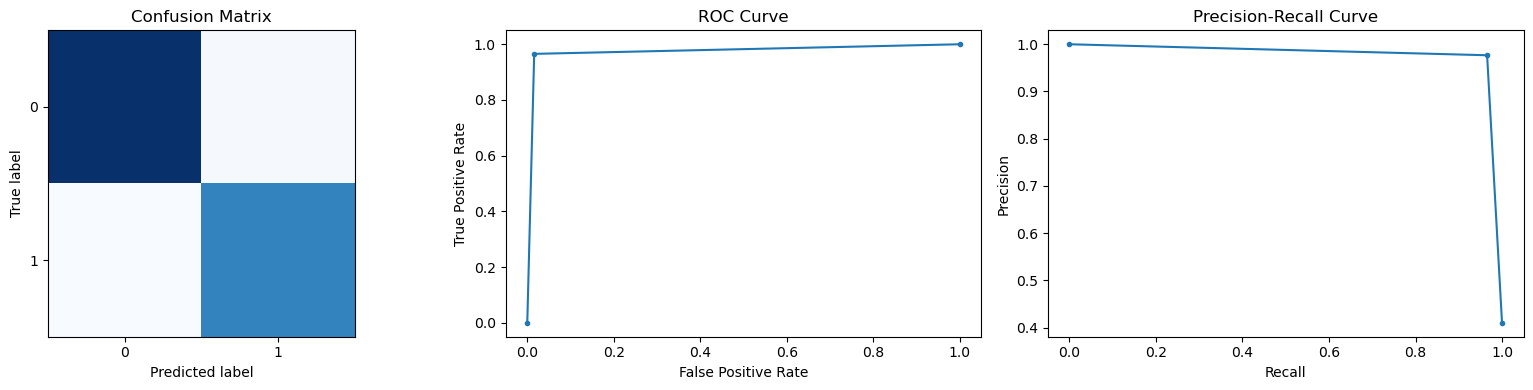


Metriche per la classificazione con regressione lineare e equazione normale di sklearn
Accuracy: 0.9764150943396226 
Precision: 0.9655172413793104 
Recall: 0.9767441860465116 
F1 Score: 0.9710982658959537 
AUC: 0.9764673311184939


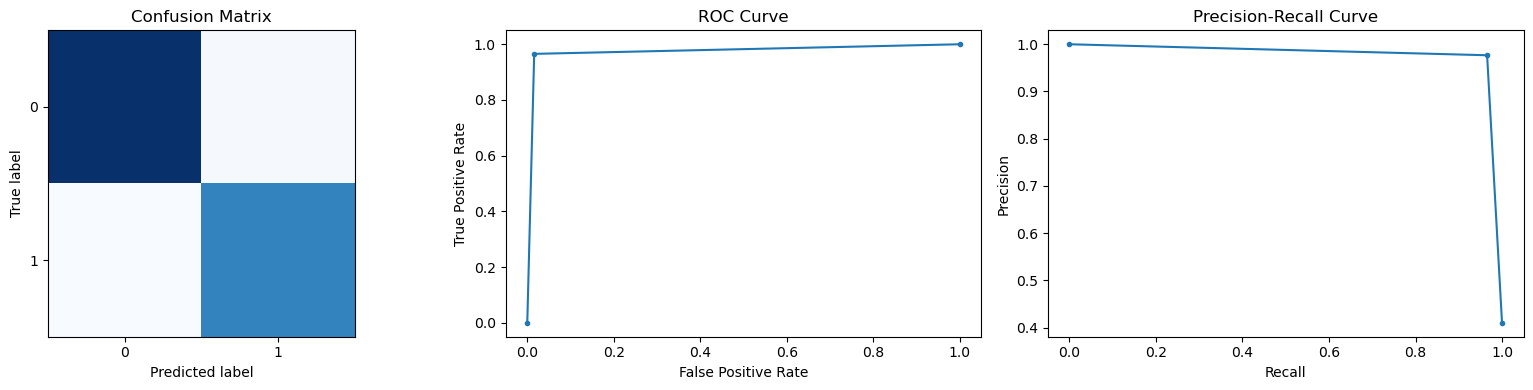

In [21]:
# Valutazione del modello con equazione normale per la classificazione

# Il mio modello

model_params = {"mode": ["classification"]}

print("Metriche per la classificazione con regressione lineare e equazione normale")
optim_params["Linear Regression"], classification_results["Linear Regression"] = model_selection(MyLinearRegressor, model_params, standardization=True, mode="classification")

# Il modello di sklearn

from sklearn.linear_model import LinearRegression

model = LinearRegression()

print("\nMetriche per la classificazione con regressione lineare e equazione normale di sklearn")
sklearn_results(model, "classification", standardization=True, round=True)

Metriche per la classificazione con regressione lineare e discesa del gradiente
Accuracy: 0.9622641509433962 
Precision: 0.9655172413793104 
Recall: 0.9438202247191011 
F1 Score: 0.9545454545454545 
AUC: 0.9597149904083311


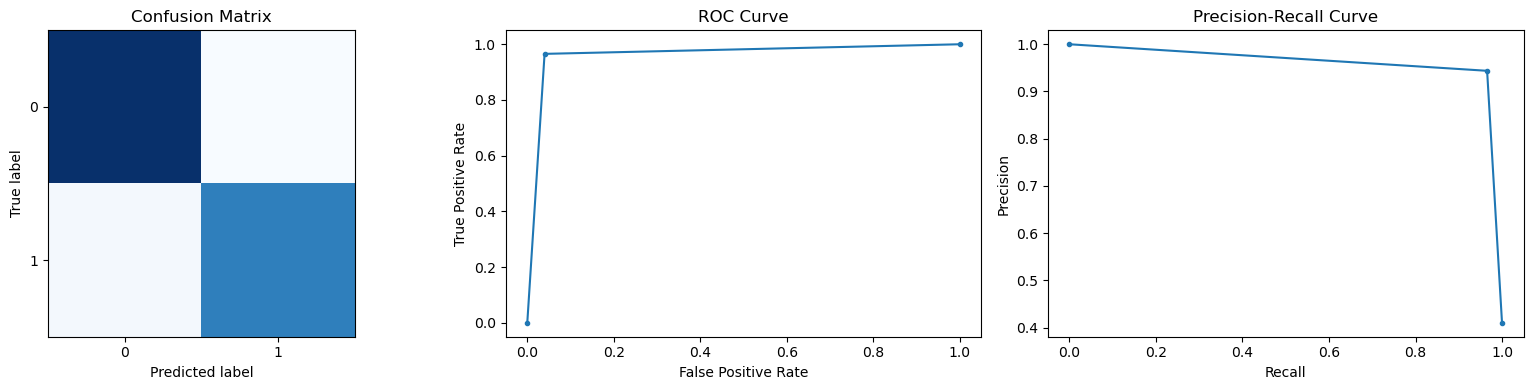


Metriche per la classificazione con regressione lineare e discesa del gradiente di sklearn
Accuracy: 0.9764150943396226 
Precision: 0.9655172413793104 
Recall: 0.9767441860465116 
F1 Score: 0.9710982658959537 
AUC: 0.9764673311184939


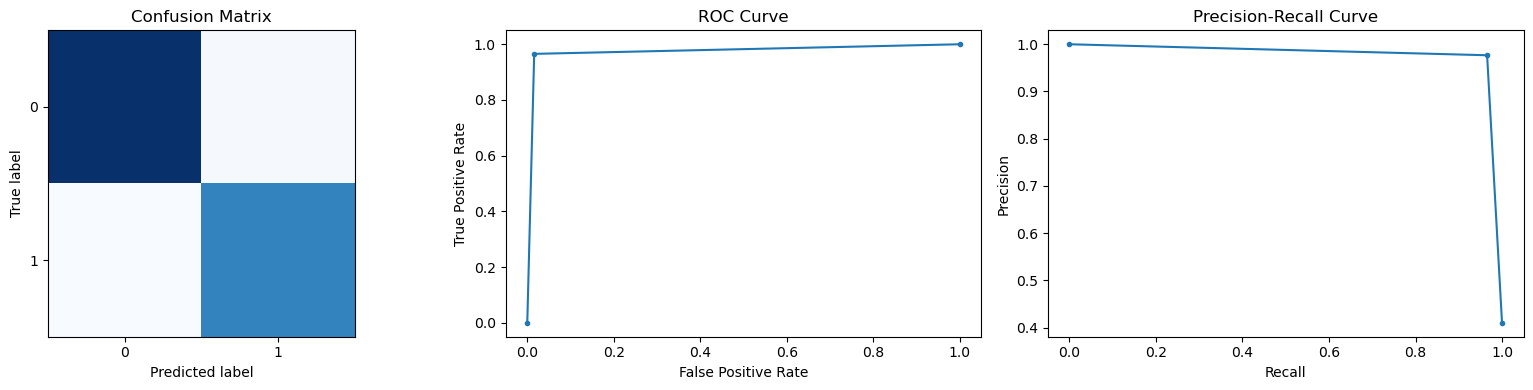

In [22]:
# Valutazione del modello con discesa del gradiente stocastico per la classificazione

# Il mio modello

model_params = {
    "mode": ["classification"],
    "alpha": [0.1],
    "lambda1": [0],
    "lambda2": [0],
    "num_iterations": [10000],
    "cutoff": [0.0001],
    "batch": [20]
    }

print("Metriche per la classificazione con regressione lineare e discesa del gradiente")
optim_params["Linear Regression GD"], classification_results["Linear Regression GD"] = model_selection(MyLinearRegressor, model_params, standardization=True, mode="classification")

# Il modello di sklearn

from sklearn.linear_model import SGDRegressor

max_iter = optim_params["Linear Regression GD"]["num_iterations"]
alpha = optim_params["Linear Regression GD"]["alpha"]
tol = optim_params["Linear Regression GD"]["cutoff"]

model = SGDRegressor(max_iter=max_iter, tol=tol)

print("\nMetriche per la classificazione con regressione lineare e discesa del gradiente di sklearn")
sklearn_results(model, "classification", standardization=True, round=True)

### Desicion Tree Classification


#### Implementazione


In [23]:
# Implementazione di un albero di decisione

class MyDesicionTreeClassifier:

    def __init__(self, h_max=None):
        self.h_max = h_max  # massima profondità dell'albero

    def entropy(self, q):  # calcola l'entropia per un dato valore di probabilità q
        if q <= 0 or q >= 1:
            return 0
        return -(q * np.log2(q) + (1 - q) * np.log2(1 - q))

    def plurality_value(self, examples):  # restituisce la classe più comune tra gli esempi
        return round(np.mean(examples[:, -1]))

    def same_classification(self, examples):  # controlla se tutti gli esempi appartengono alla stessa classe
        return np.all(examples[:, -1] == examples[0, -1])

    def pos_neg_examples(self, array):  # conta il numero di esempi positivi e negativi
        pos = np.sum(array)
        return pos, len(array) - pos

    def fit(self, X, Y):  # addestra l'albero di decisione

        # controlla se h_max è None
        if self.h_max == None:
            self.h_max = X.shape[1]

        # inizializza l'albero di decisione
        attributes = list(range(X.shape[1]))
        examples = np.concatenate((X, Y.reshape(-1, 1)), axis=1)

        # apprende l'albero di decisione
        self.tree = self.learn_decision_tree(examples, attributes, examples, self.h_max)

    def most_important(self, examples, attributes):  # trova l'attributo più importante (con il massimo guadagno di informazione)

        # calcola l'entropia dell'output
        pos, neg = self.pos_neg_examples(examples[:, -1])
        H_output = self.entropy(pos / (pos + neg))
        gain = []

        # calcola il guadagno di informazione per ogni attributo
        for attribute in attributes:
            pos, neg = self.pos_neg_examples(examples[:, attribute])
            remainder = 0

            # calcola l'entropia residua
            for value in set(examples[:, attribute]):
                exs = examples[examples[:, attribute] == value]
                pos_v, neg_v = self.pos_neg_examples(exs[:, -1])
                remainder += ((pos_v + neg_v) / (pos + neg)) * self.entropy(pos_v / (pos_v + neg_v))

            # calcola il guadagno di informazione
            gain.append(H_output - remainder)

        # restituisce l'attributo con il massimo guadagno
        return attributes[np.argmax(gain)]

    def get_values(self, array):  # restituisce i valori unici di un array in ordine di occorrenza
        return sorted(set(array), key=lambda x: np.sum(array == x), reverse=True)

    def learn_decision_tree(self, examples, attributes, parent_examples, h):  # apprende l'albero di decisione ricorsivamente

        # controlla i casi base
        if len(examples) == 0 or h == 0:
            return self.plurality_value(parent_examples)

        # controlla se tutti gli esempi appartengono alla stessa classe o se non ci sono più attributi
        if self.same_classification(examples) or len(attributes) == 0:
            return self.plurality_value(examples)

        # trova l'attributo più importante (con il massimo guadagno di informazione)
        attribute = self.most_important(examples, attributes)
        tree = {attribute: {}}

        # costruisce l'albero di decisione
        for value in self.get_values(examples[:, attribute]):
            subtree_examples = examples[examples[:, attribute] == value]
            subtree_attributes = [a for a in attributes if a != attribute]
            tree[attribute][value] = self.learn_decision_tree(subtree_examples, subtree_attributes, examples, h - 1)

        return tree

    def get_prediction(self, x, tree):  # ottiene la previsione per un dato esempio x

        # controlla se l'albero è una foglia
        if type(tree) == int:
            return tree

        # controlla se l'attributo dell'albero è presente nell'esempio altrimenti sceglie il più comune
        key = list(tree.keys())[0]
        value = x[key] if x[key] in tree[key].keys() else list(tree[key].keys())[0]
        subtree = tree[key][value]

        # chiama ricorsivamente get_prediction
        return self.get_prediction(x, subtree)

    def predict(self, X):  # ottiene le previsioni per un insieme di esempi X
        return [self.get_prediction(x, self.tree) for x in X]

#### Classificazione


Accuracy: 0.9764150943396226 
Precision: 0.9655172413793104 
Recall: 0.9767441860465116 
F1 Score: 0.9710982658959537 
AUC: 0.9764673311184939


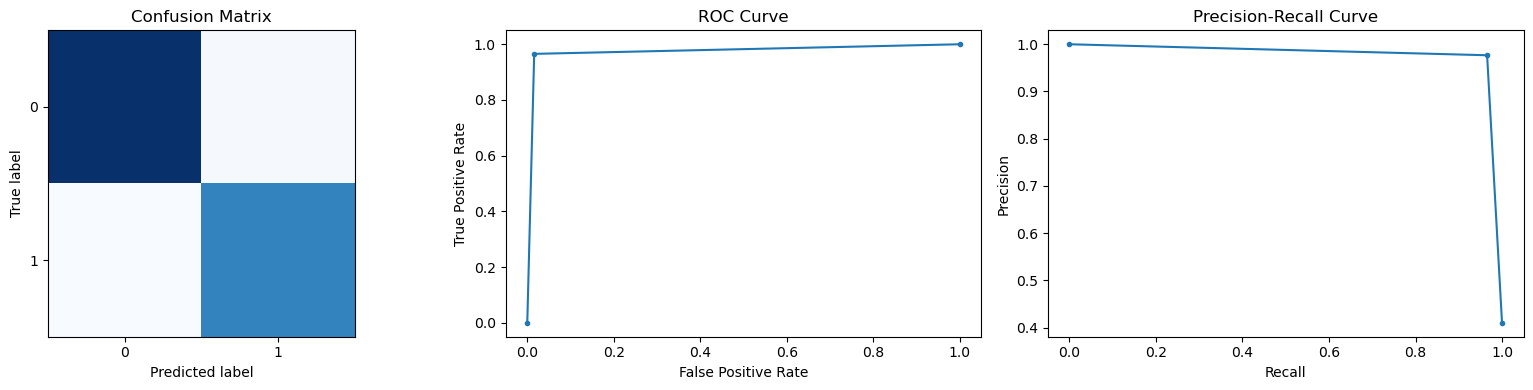

Accuracy: 1.0 
Precision: 1.0 
Recall: 1.0 
F1 Score: 1.0 
AUC: 1.0


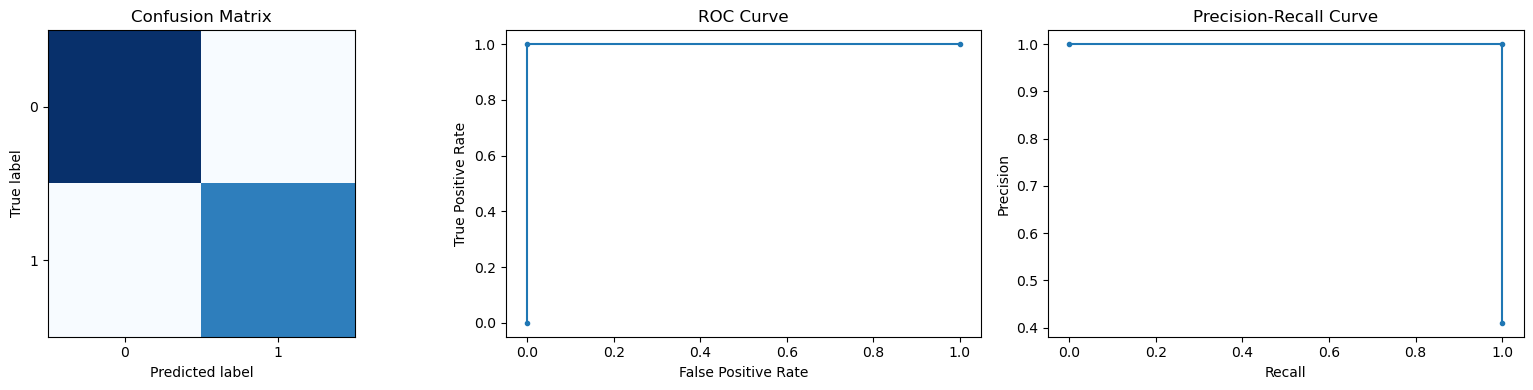

In [24]:
# Valutazione dell'albero di decisione

# Il mio modello

model_params = {"h_max": range(0, 22)}

optim_params["Desicion Tree"], classification_results["Desicion Tree"] = model_selection(MyDesicionTreeClassifier, model_params, bins=10, mode="classification")

# Il modello di sklearn

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

sklearn_results(model, "classification")

#### VIsualizzazione


In [25]:
def prepare_tree(tree, cols): # Prepara l'albero per la visualizzazione con printree
    copy = {}

    # controlla se l'albero è una foglia
    if type(tree) == int:
        return "> " + str(tree)

    # costruisce l'albero ricorsivamente
    key = list(tree.keys())[0]
    attr = cols[key]
    copy[attr] = {}
    for v in tree[key]:
        copy[attr][v] = prepare_tree(tree[key][v], cols)

    return copy

def print_tree(bins = 5, h_max = 5): # Stampa l'albero di decisione

    # codifica i dati
    e = Encoder('classification', bins=bins)
    x_train, y_train = e.fit_transform(dataset_training)

    # addestra l'albero di decisione
    model = MyDesicionTreeClassifier(h_max = h_max)
    model.fit(x_train, y_train)

    # ottiene le colonne del dataset
    columns = e.encoding(dataset_training).columns
    columns = [x for x in columns if x != 'NObeyesdad']

    # prepara l'albero per la visualizzazione
    tree = prepare_tree(model.tree, columns)

    # stampa l'albero
    print("Per ciascun attributo, il valore rappresenta il valore dell'attributo (in ordine di occorrenza) e il sottoalbero associato.")
    ptree(tree)

In [26]:
# Visualizzazione dell'albero di decisione con print_tree

print_tree(bins = 10, h_max = optim_params["Desicion Tree"]['h_max'])

Per ciascun attributo, il valore rappresenta il valore dell'attributo (in ordine di occorrenza) e il sottoalbero associato.
┐
└── Weight
    ├── 3
    │   └── Height
    │       ├── 4
    │       │   └── Age
    │       │       ├── 1
    │       │       │   └── TUE
    │       │       │       ├── 4
    │       │       │       │   └── FCVC
    │       │       │       │       ├── 4: > 1
    │       │       │       │       ├── 5: > 1
    │       │       │       │       ├── 6: > 1
    │       │       │       │       ├── 8: > 1
    │       │       │       │       └── 9: > 1
    │       │       │       ├── 7: > 0
    │       │       │       ├── 6: > 0
    │       │       │       ├── 5: > 0
    │       │       │       ├── 8: > 0
    │       │       │       └── 0: > 0
    │       │       ├── 0
    │       │       │   └── FAVC
    │       │       │       ├── 1
    │       │       │       │   └── NCP
    │       │       │       │       ├── 6: > 1
    │       │       │       │       └── 5: > 1
  

### Logistic Regression


#### Implementazione


In [27]:
# Implementazione del modello di regressione logistica

class MyLogisticRegressor:

    def __init__(self, lambda1=0, lambda2=0, alpha=0.01, num_iterations=1000, cutoff=0.01, batch=-1):
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.alpha = alpha
        self.num_iterations = num_iterations
        self.cutoff = cutoff
        self.stocastic = batch != -1
        if self.stocastic:
            self.batch = batch

    def concat_ones(self, X):  # aggiunge una colonna di 1 per il termine noto
        return np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

    def sigmoid(self, z):  # funzione sigmoide

        # evita l'overflow
        z = np.clip(z, -500, 500)

        return 1 / (1 + np.exp(-z))

    def threshold(self, z):  # calcola la soglia per la classificazione
        return (z > 0.5).astype(int)

    def get_random_batch(self, X, Y): # Prende un batch casuale di dimensione batch
        indices = np.random.choice(np.arange(X.shape[0]), size=self.batch, replace=False)
        return X[indices], Y[indices]

    def gradient(self, x, y):  # calcola il gradiente

        # Se è stata specificata una dimensione del batch, prende un batch casuale
        if self.stocastic:
            x, y = self.get_random_batch(x, y)

        y_pred = self.threshold(self.sigmoid(np.dot(self.w, x.T)))
        return np.dot((y - y_pred), x)

    def fit(self, X, Y):  # addestra il modello
        X = self.concat_ones(X)

        # inizializza i pesi con valori casuali
        self.w = np.zeros(X.shape[1])

        # addestra il modello
        for _ in range(self.num_iterations):
            prev_w = self.w.copy()

            # calcola il gradiente
            gradient = self.gradient(X, Y)

            # aggiorna i pesi
            self.w += self.alpha * (gradient + self.lambda1 * np.sign(self.w) + self.lambda2 * self.w)

            # controlla la convergenza
            max_diff = np.max(np.abs(self.w - prev_w))
            if max_diff < self.cutoff:
                break

    def predict(self, X):  # predice i valori
        X = self.concat_ones(X)
        return self.threshold(self.sigmoid(np.dot(self.w, X.T)))

#### Classificazione


Accuracy: 0.9905660377358491 
Precision: 0.9885057471264368 
Recall: 0.9885057471264368 
F1 Score: 0.9885057471264368 
AUC: 0.9902528735632183


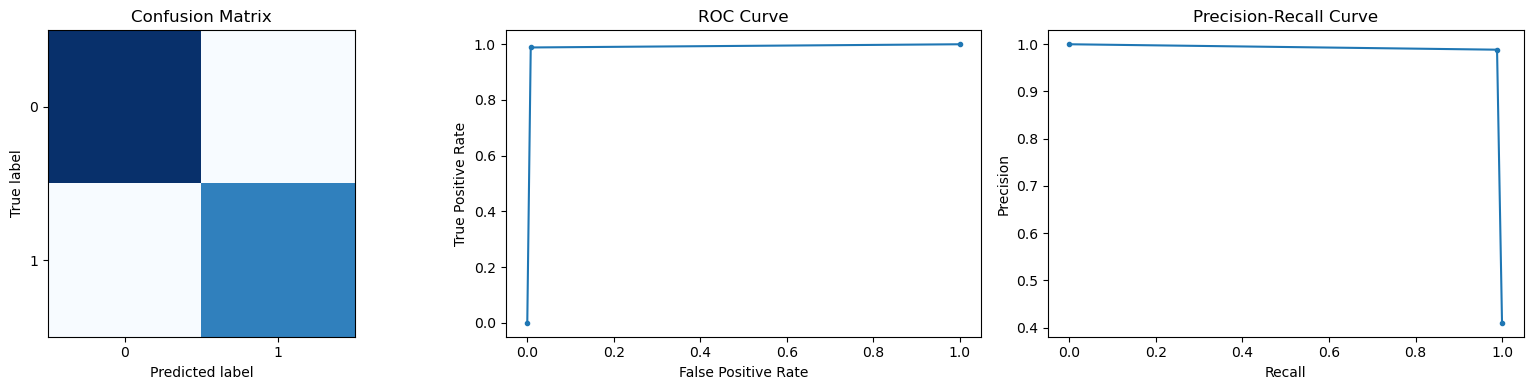

Accuracy: 0.9905660377358491 
Precision: 0.9885057471264368 
Recall: 0.9885057471264368 
F1 Score: 0.9885057471264368 
AUC: 0.9902528735632183


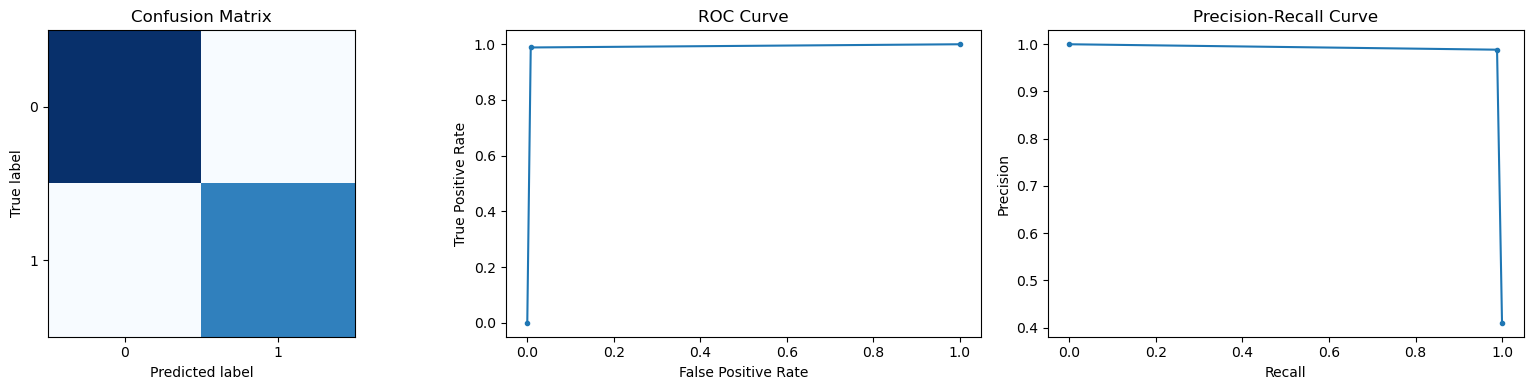

In [28]:
# Valutazione del modello di regressione logistica

# Il mio modello

model_params = {
    "lambda1": [0],
    "lambda2": [0],
    "alpha": [0.1],
    "num_iterations": [10000],
    "cutoff": [0.001],
}

optim_params["Logistic Regression GD"], classification_results["Logistic Regression GD"] = model_selection(MyLogisticRegressor, model_params, standardization=True, mode="classification")

# Il modello di sklearn

from sklearn.linear_model import LogisticRegression

max_iter = optim_params["Logistic Regression GD"]["num_iterations"]
tol = optim_params["Logistic Regression GD"]["cutoff"]

model = LogisticRegression(max_iter=max_iter, tol=tol, solver="newton-cg")

sklearn_results(model, "classification", standardization=True)

Accuracy: 0.9669811320754716 
Precision: 0.9885057471264368 
Recall: 0.9347826086956522 
F1 Score: 0.9608938547486033 
AUC: 0.9632246376811595


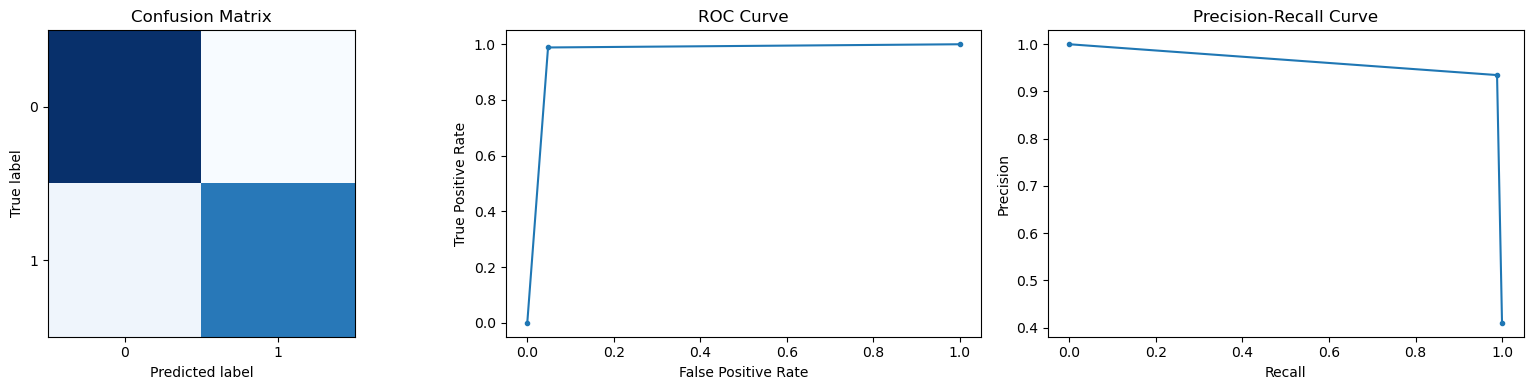

Accuracy: 0.9905660377358491 
Precision: 0.9885057471264368 
Recall: 0.9885057471264368 
F1 Score: 0.9885057471264368 
AUC: 0.9902528735632183


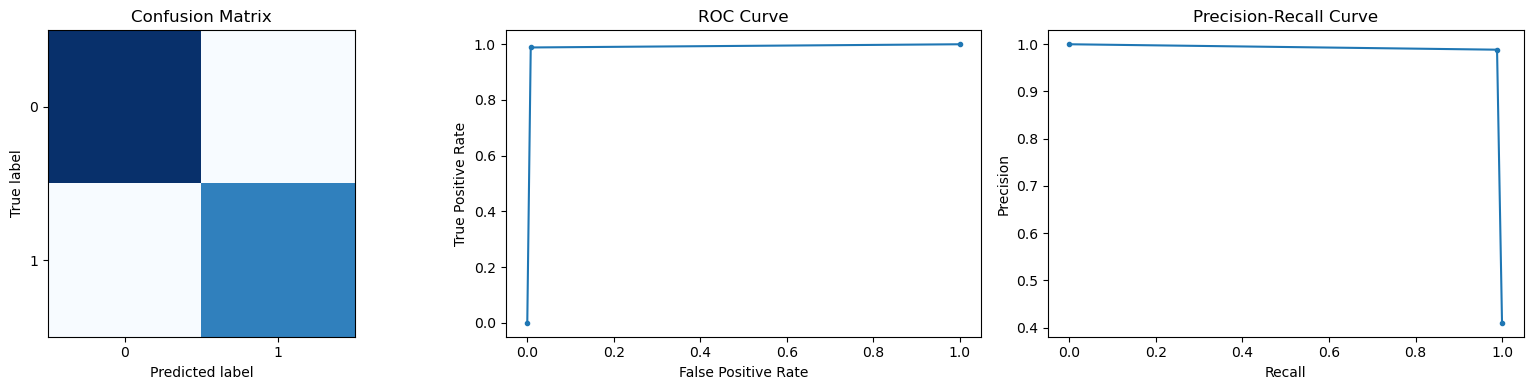

In [29]:
# Valutazione del modello di regressione logistica stocastica

# Il mio modello

model_params = {
    "lambda1": [0],
    "lambda2": [0],
    "alpha": [0.01],
    "num_iterations": [10000],
    "cutoff": [0.001],
    "batch": [50]
}

optim_params["Logistic Regression SGD"], classification_results["Logistic Regression SGD"] = model_selection(MyLogisticRegressor, model_params, standardization=True, mode="classification")

# Il modello di sklearn

from sklearn.linear_model import LogisticRegression

max_iter = optim_params["Logistic Regression SGD"]["num_iterations"]
tol = optim_params["Logistic Regression SGD"]["cutoff"]

model = LogisticRegression(max_iter=max_iter, tol=tol, solver="sag")

sklearn_results(model, "classification", standardization=True)

##### Regularization


Accuracy: 0.9716981132075472 
Precision: 0.9770114942528736 
Recall: 0.9550561797752809 
F1 Score: 0.9659090909090908 
AUC: 0.9693980085868275


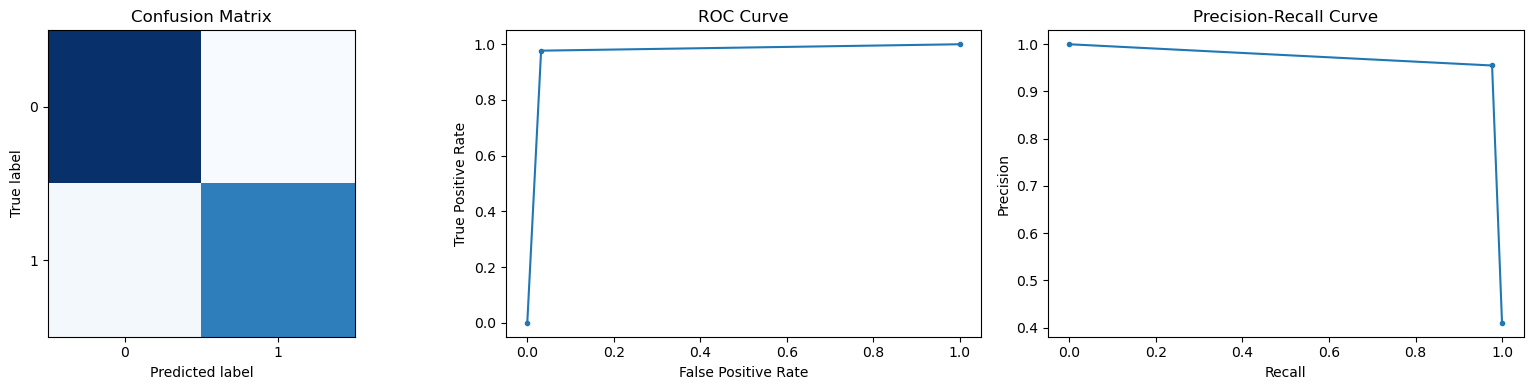

Accuracy: 1.0 
Precision: 1.0 
Recall: 1.0 
F1 Score: 1.0 
AUC: 1.0


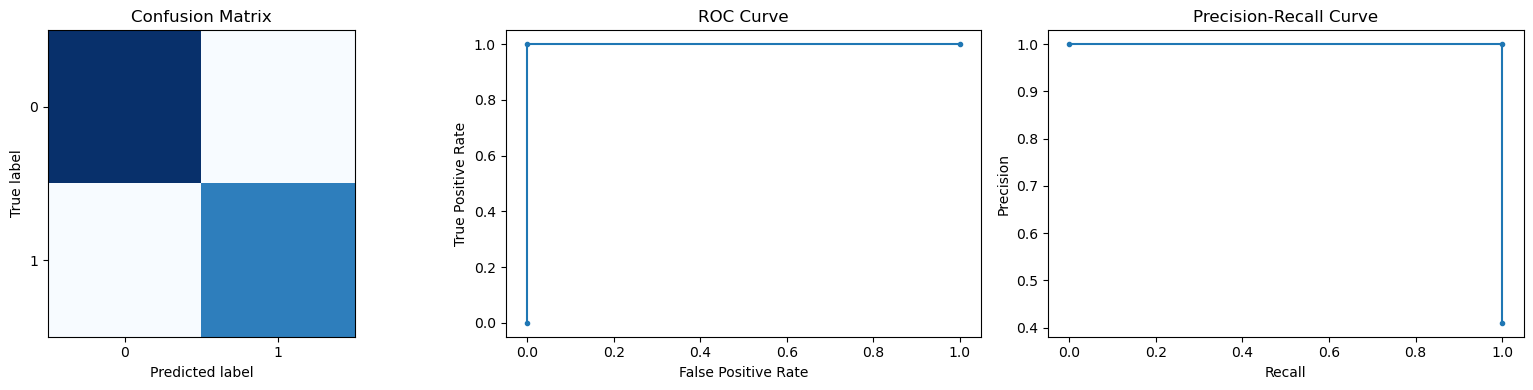

In [30]:
# Valutazione del modello di regressione logistica stocastica con regolarizzazione L1

model_params = {
    "lambda1": [0.1],
    "lambda2": [0],
    "alpha": [0.1],
    "num_iterations": [10000],
    "cutoff": [0.001],
    "batch": [20]
}

optim_params["Logistic Regression GD"], classification_results["Logistic Regression GD"] = model_selection(MyLogisticRegressor, model_params, standardization=True, mode="classification")

# Il modello di sklearn

from sklearn.linear_model import LogisticRegression

max_iter = optim_params["Logistic Regression GD"]["num_iterations"]
tol = optim_params["Logistic Regression GD"]["cutoff"]

model = LogisticRegression(max_iter=max_iter, tol=tol, solver="saga", penalty="l1")

sklearn_results(model, "classification", standardization=True)

Accuracy: 0.9905660377358491 
Precision: 0.9885057471264368 
Recall: 0.9885057471264368 
F1 Score: 0.9885057471264368 
AUC: 0.9902528735632183


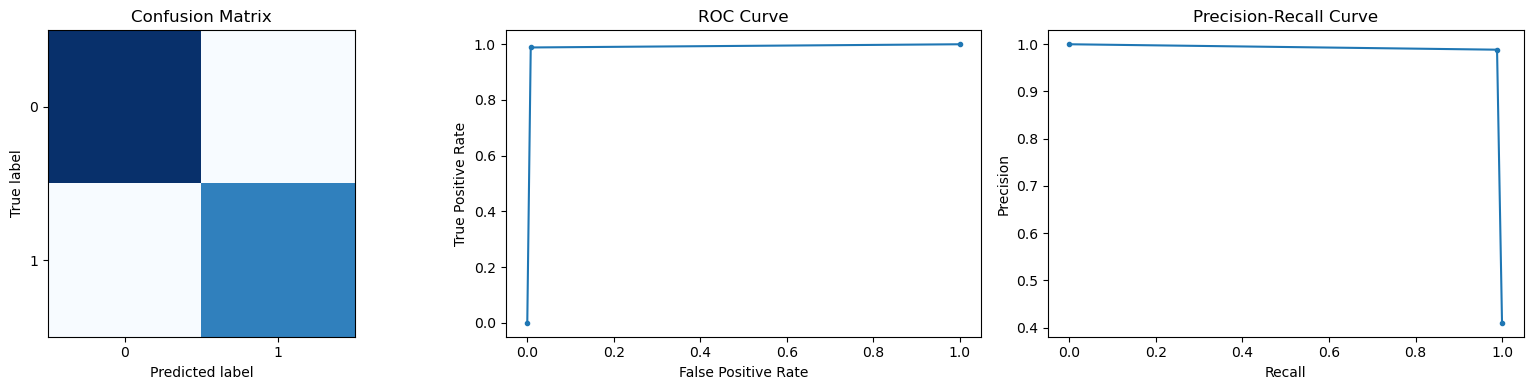

Accuracy: 0.9905660377358491 
Precision: 0.9885057471264368 
Recall: 0.9885057471264368 
F1 Score: 0.9885057471264368 
AUC: 0.9902528735632183


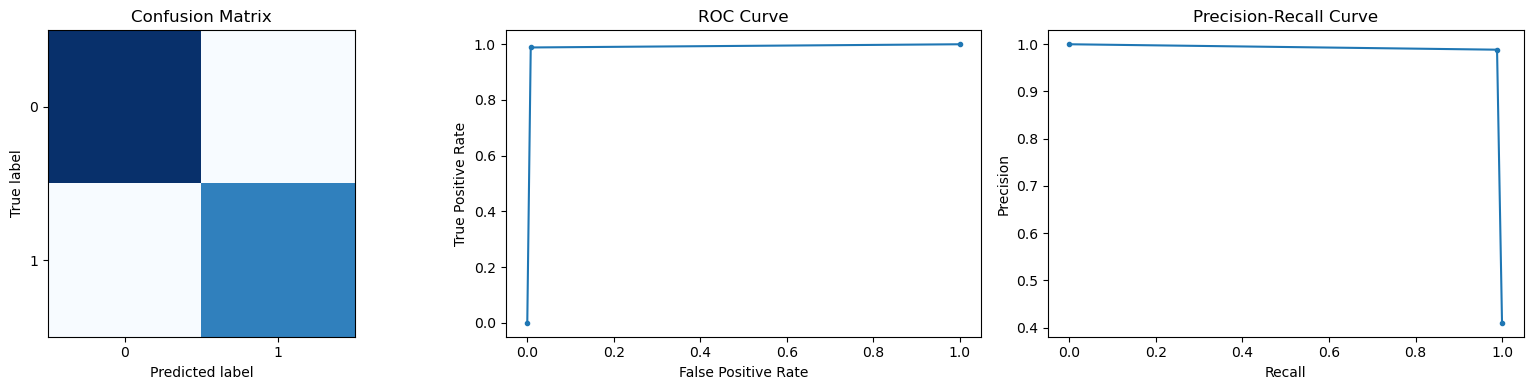

In [31]:
# Valutazione del modello di regressione logistica stocastica con regolarizzazione L2

model_params = {
    "lambda1": [0],
    "lambda2": [0.1],
    "alpha": [0.1],
    "num_iterations": [10000],
    "cutoff": [0.001],
    "batch": [20]
}

optim_params["Logistic Regression GD"], classification_results["Logistic Regression GD"] = model_selection(MyLogisticRegressor, model_params, standardization=True, mode="classification")

# Il modello di sklearn

from sklearn.linear_model import LogisticRegression

max_iter = optim_params["Logistic Regression GD"]["num_iterations"]
tol = optim_params["Logistic Regression GD"]["cutoff"]

model = LogisticRegression(max_iter=max_iter, tol=tol, solver="saga", penalty="l2")

sklearn_results(model, "classification", standardization=True)

Accuracy: 0.9811320754716981 
Precision: 0.9885057471264368 
Recall: 0.9662921348314607 
F1 Score: 0.9772727272727273 
AUC: 0.9790810267653238


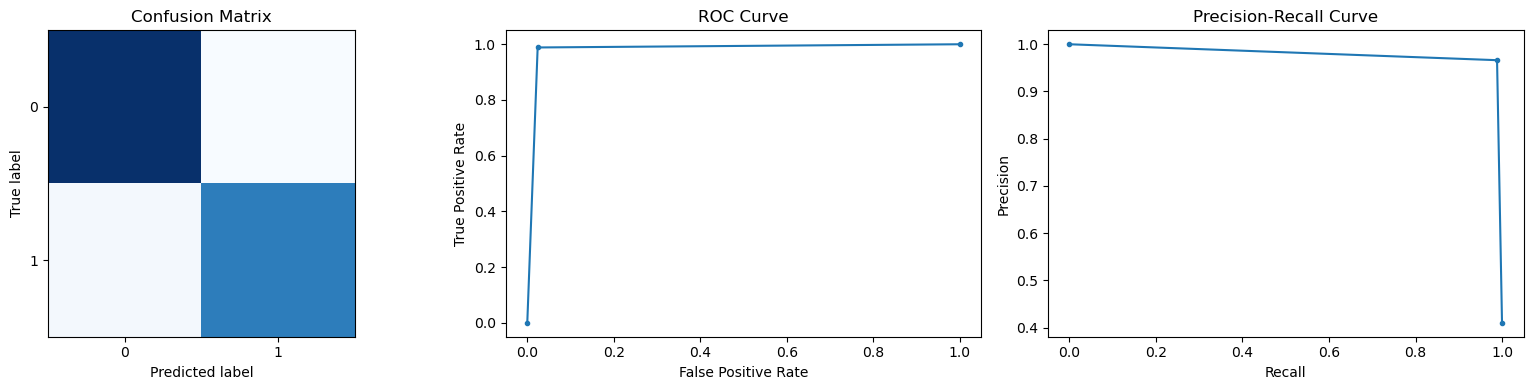

Accuracy: 0.9952830188679245 
Precision: 0.9885057471264368 
Recall: 1.0 
F1 Score: 0.9942196531791908 
AUC: 0.996031746031746


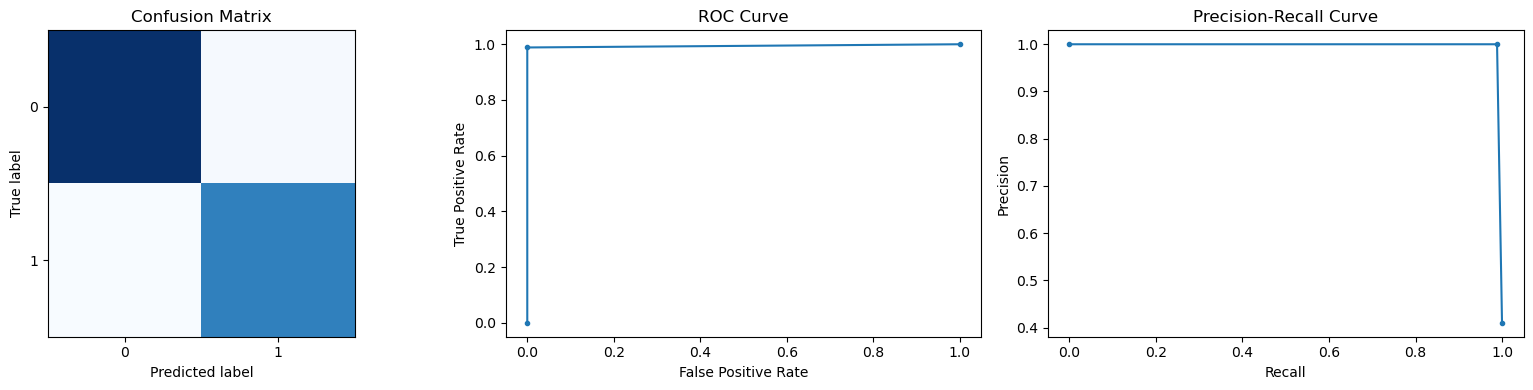

In [32]:
# Valutazione del modello di regressione logistica stocastica con regolarizzazione L1 + L2

model_params = {
    "lambda1": [0.1],
    "lambda2": [0.1],
    "alpha": [0.1],
    "num_iterations": [10000],
    "cutoff": [0.001],
    "batch": [20]
}

optim_params["Logistic Regression GD"], classification_results["Logistic Regression GD"] = model_selection(MyLogisticRegressor, model_params, standardization=True, mode="classification")

# Il modello di sklearn

from sklearn.linear_model import LogisticRegression

max_iter = optim_params["Logistic Regression GD"]["num_iterations"]
tol = optim_params["Logistic Regression GD"]["cutoff"]
li_ratio = optim_params["Logistic Regression GD"]["lambda1"] / optim_params["Logistic Regression GD"]["lambda1"] + optim_params["Logistic Regression GD"]["lambda2"]

model = LogisticRegression(max_iter=max_iter, tol=tol, solver="saga", penalty="elasticnet", l1_ratio=l1_ratio)

sklearn_results(model, "classification", standardization=True)

### Nearest-Neighbor


#### Implementazione


In [33]:
# Implementazione del modello K-Nearest Neighbors

class NearestNeighbors:

    def __init__(self, mode, method = None, k=3, p=2): # Inizializza il modello
        self.k = k
        self.p = p
        
        # Imposta il metodo in base alla modalità
        if mode == "classification":
            self.method = "classification"
        else:
            self.method = method

    def fit(self, X, Y): # Salva i dati di addestramento
        self.X = X
        self.Y = Y

    def minkowski_distance(self, x1, x2, p): # Calcola la distanza di Minkowski
        return np.sum(np.abs(x1 - x2) ** p, axis=1) ** (1 / p)

    def NN(self, x): # Trova gli indici dei k vicini
        distances = self.minkowski_distance(x, self.X, self.p)
        indices = np.argsort(distances)[:self.k]
        return indices

    def kernel(self, d): # Calcola il kernel quadratico
        return np.maximum(0, 1 - (2 * d / self.w) ** 2)

    def classify(self, indices): # Discretizza i valori per la classificazione 
        return np.round(np.mean(self.Y[indices], axis=1)).astype(int)

    def average(self, indices): # Calcola la media dei valori per la regressione
        return np.mean(self.Y[indices], axis=1)
 
    def predict(self, X): # Predice i valori in base alla modalità
        indices = np.apply_along_axis(self.NN, 1, X)
        if self.method == "classification":
            return self.classify(indices)
        if self.method == "average":
            return self.average(indices)

#### Regressione


meglio senza standardizzazione


In [34]:
# Valutazione del modello KNN per la regressione

# Il mio modello

model_params = {
    "mode": ["regression"],
    "method": ["average"],
    "k": [5],
    "p": [2],
}

print("Metriche per il KNN Regression")
optim_params["KNN Regression"], regression_results["KNN Regression"] = model_selection(NearestNeighbors, model_params, mode="regression")

# Il modello di sklearn

from sklearn.neighbors import KNeighborsRegressor

n_neighbors = optim_params["KNN Regression"]["k"]
p = optim_params["KNN Regression"]["p"]
weights = "uniform"

model = KNeighborsRegressor(n_neighbors=n_neighbors, p=p, weights=weights)

print("\nMetriche per il KNN Regression di sklearn")
sklearn_results(model, "regression")

Metriche per il KNN Regression
MSE: 34.48570689032632 
MAE: 3.5246160566037736 
RMSE: 5.872453225895147

Metriche per il KNN Regression di sklearn
MSE: 34.48570689032632 
MAE: 3.5246160566037736 
RMSE: 5.872453225895147


#### Classificazione


Metriche per il KNN Classification
Accuracy: 0.9905660377358491 
Precision: 1.0 
Recall: 0.9775280898876404 
F1 Score: 0.9886363636363636 
AUC: 0.9887640449438202


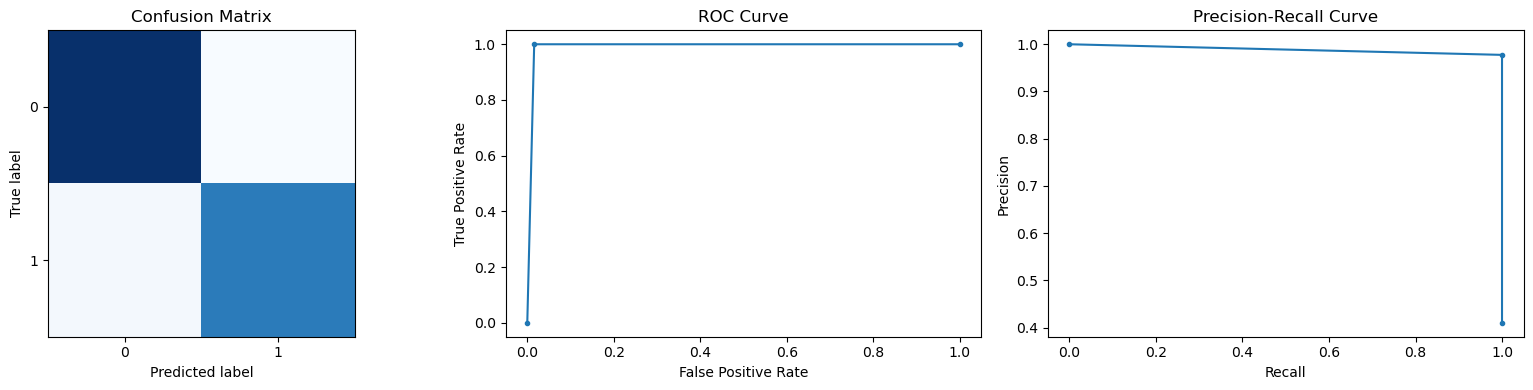


Metriche per il KNN Classification di sklearn
Accuracy: 0.9858490566037735 
Precision: 1.0 
Recall: 0.9666666666666667 
F1 Score: 0.983050847457627 
AUC: 0.9833333333333334


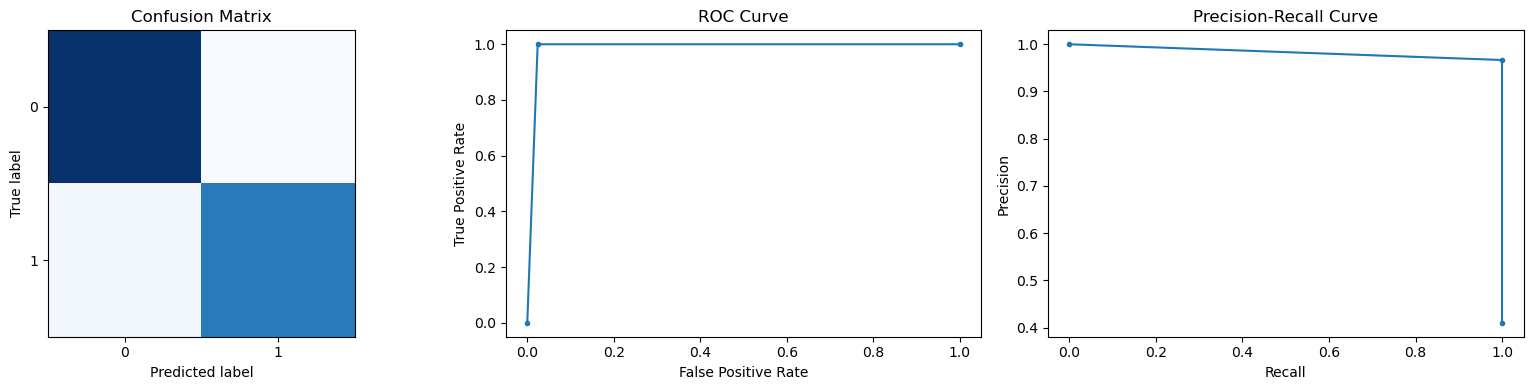

In [35]:
# Valutazione del modello KNN per la classificazione

# Il mio modello

model_params = {
    "mode": ["classification"],
    "k": [5],
    "p": [2],
}

print("Metriche per il KNN Classification")
optim_params["KNN Classification"], classification_results["KNN Classification"] = model_selection(NearestNeighbors, model_params, mode="classification")

# Il modello di sklearn

from sklearn.neighbors import KNeighborsClassifier

n_neighbors = optim_params["KNN Classification"]["k"]
p = optim_params["KNN Classification"]["p"]
weights = "uniform"

model = KNeighborsClassifier(n_neighbors=n_neighbors, p=p, weights=weights)

print("\nMetriche per il KNN Classification di sklearn")
sklearn_results(model, "classification")

#### Implementazione


In [36]:
class SVM:
    def __init__(self, C=1.0):
        self.C = C

    def fit(self, X, y):
        y = (y * 2) - 1  # Converti le etichette in -1 e 1

        n_samples = X.shape[0]

        # Convert data to cvxopt format
        P = matrix(np.outer(y, y) * np.dot(X, X.T))
        q = matrix(-np.ones((n_samples, 1)))
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))
        A = matrix(y.astype(float).reshape(1, -1))
        b = matrix(np.zeros(1))

        # Solve the quadratic programming problem
        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h, A, b)
        a = np.ravel(solution['x'])

        # Compute the weight vector
        self.w = sum(a[i] * y[i] * X[i] for i in range(n_samples))

        # Compute the bias term
        cond = (a > 1e-4)
        self.b = np.mean(y[cond] - np.dot(X[cond], self.w))

    def predict(self, X):
        y_pred = np.sign(np.dot(X, self.w) - self.b)
        return  (y_pred == 1).astype(int)


#### Classificazione


Accuracy: 0.9858490566037735 
Precision: 0.9885057471264368 
Recall: 0.9772727272727273 
F1 Score: 0.9828571428571428 
AUC: 0.9846041055718475


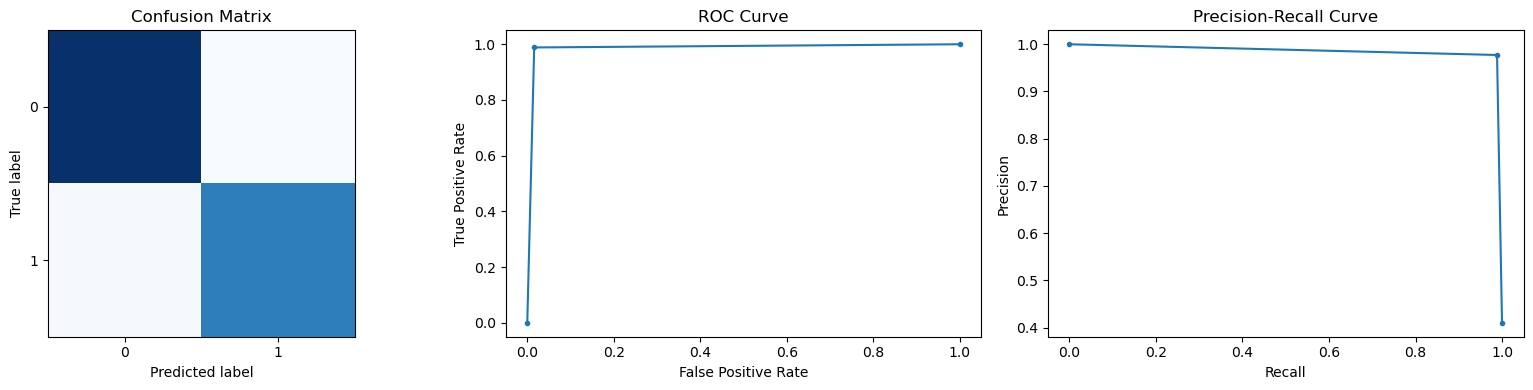

In [37]:
# Valutazione del modello SVM per la classificazione

model_params = {
    "C": [1.0],
}

optim_params["SVM"], classification_results["SVM"] = model_selection(SVM, model_params, mode="classification", standardization=True)

Accuracy: 0.9952830188679245 
Precision: 0.9885057471264368 
Recall: 1.0 
F1 Score: 0.9942196531791908 
AUC: 0.996031746031746


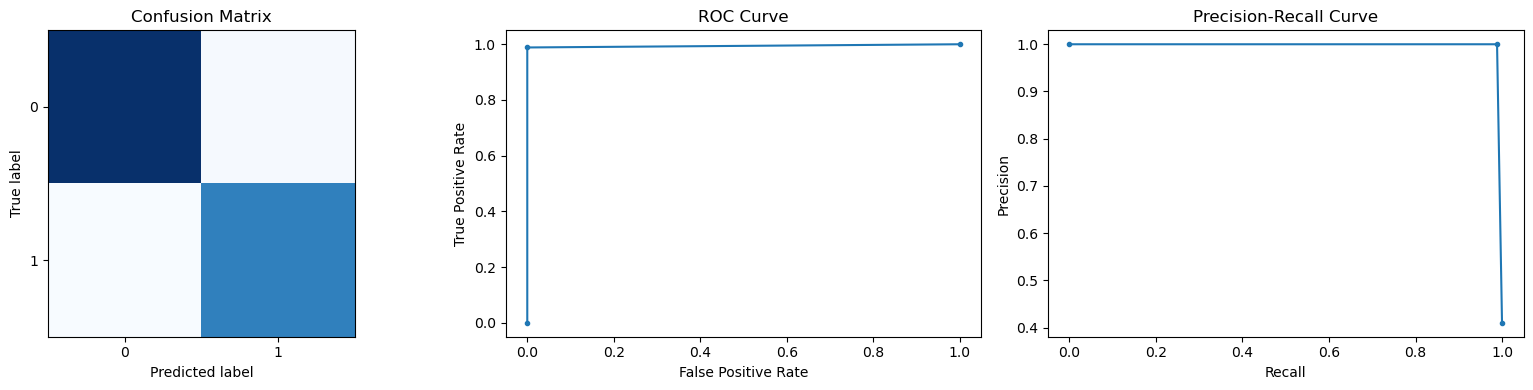

In [38]:
# Valutazione del modello SVM per la classificazione con sklearn

from sklearn.svm import SVC

C = optim_params["SVM"]["C"]
kernel = "linear"

sklearn_results(SVC(C=C, kernel=kernel), "classification", standardization=True)

### Neural Network


#### Implementazione


In [39]:
class MyNeuralNetwork:

    def __init__(self, mode, hidden_layer_sizes, n_epochs=1000, learning_rate=0.01): # Inizializza il modello
        assert mode in ["classification", "regression"]
        self.hidden_layer_sizes = [eval(i) for i in hidden_layer_sizes.split("-")]
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.mode = mode
        
        # Imposta la funzione di attivazione in base alla modalità 
        self.activation_function = self.sigmoid if mode == "classification" else self.relu
        self.activation_function_derivative = self.sigmoid_derivative if mode == "classification" else self.relu_derivative

    def initialize_parameters(self, X): # Inizializza i pesi e i bias
        self.weights = []
        self.biases = []
        
        # Per ogni layer
        for i in range(len(self.hidden_layer_sizes) + 1):
            
            # Calcola il numero di neuroni di input e output
            if i == 0:
                n_input_neurons = X.shape[1]
            else:
                n_input_neurons = self.hidden_layer_sizes[i - 1]
            if i == len(self.hidden_layer_sizes):
                n_output_neurons = 1
            else:
                n_output_neurons = self.hidden_layer_sizes[i]

            # Inizializza i pesi e i bias con valori casuali
            self.weights.append(np.random.rand(n_input_neurons, n_output_neurons))
            self.biases.append(np.random.rand(n_output_neurons))

    def sigmoid(self, x): # Funzione sigmoide
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, y): # Derivata della funzione sigmoide
        return y * (1 - y)

    def relu(self, x): # Funzione ReLU
        return np.maximum(0, x)

    def relu_derivative(self, y): # Derivata della funzione ReLU
        return (y > 0).astype(int)

    def forward_propagation(self, X): # Propagazione in avanti
        
        # Inizializza l'output con i dati di input
        a = X 
        self.outputs = [a]
        
        # Per ogni layer
        for i in range(len(self.weights)):
            
            # Calcola l'output
            z = np.dot(a, self.weights[i]) + self.biases[i]
            z = self.activation_function(z)
            a = z
            
            # Salva l'output 
            self.outputs.append(a)
            
        return a

    def backpropagation(self, y, a): # Propagazione all'indietro
        
        # Inizializza i gradienti
        grad_weights = [np.zeros_like(w) for w in self.weights]
        grad_biases = [np.zeros_like(b) for b in self.biases]

        # Inizializza l'errore
        delta = a - y.reshape(-1, 1)
        
        # Per ogni layer
        for i in reversed(range(len(self.weights))):
            
            # Calcola il gradiente
            delta = delta * self.activation_function_derivative(self.outputs[i+1])
            
            # Aggiorna i pesi e i bias
            grad_weights[i] = np.dot(self.outputs[i].T, delta)
            grad_biases[i] = np.mean(delta, axis=0)
            
            # Calcola l'errore per il layer precedente
            delta = np.dot(delta, self.weights[i].T)
            
        return grad_weights, grad_biases

    def fit(self, X, y): # Addestra il modello
        
        # Inizializza i pesi e i bias
        self.initialize_parameters(X)

        # Per ogni epoca
        for _ in range(self.n_epochs):
            
            # Propagazione in avanti
            a = self.forward_propagation(X)

            # Propagazione all'indietro
            grad_weights, grad_biases = self.backpropagation(y, a)

            # Aggiorna i pesi e i bias
            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * grad_weights[i]
                self.biases[i] -= self.learning_rate * grad_biases[i]

    def predict(self, X): # Predice i valori
        a = self.forward_propagation(X).reshape(-1)
        if self.mode == "classification":
            a = (a > 0.5).astype(int)
        return a

#### Regression


In [40]:
# Valutazione del modello di rete neurale per la regressione

# Il mio modello

model_params = {
    "mode": ["regression"],
    "hidden_layer_sizes": ["10-10"],
    "n_epochs": [2000],
    "learning_rate": [0.0001],
}

print("Metriche per la Neural Network Regression")
optim_params["Neural Network Regression"], regression_results["Neural Network Regression"] = model_selection(MyNeuralNetwork, model_params, mode="regression", standardization=True)


# Il modello di sklearn

from sklearn.neural_network import MLPRegressor

hidden_layer_sizes = list(map(int, optim_params["Neural Network Regression"]["hidden_layer_sizes"].split("-")))
n_epochs = optim_params["Neural Network Regression"]["n_epochs"]
learning_rate = optim_params["Neural Network Regression"]["learning_rate"]

model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, max_iter=n_epochs, learning_rate_init=learning_rate, activation="relu")

print("\nMetriche per la Neural Network Regression di sklearn")
sklearn_results(model, "regression", standardization=True)


Metriche per la Neural Network Regression


MSE: 8059.470770624201 
MAE: 85.91350874999999 
RMSE: 89.77455525160902

Metriche per la Neural Network Regression di sklearn
MSE: 37.82692902762666 
MAE: 4.447102543054154 
RMSE: 6.1503600730060235


c:\Users\alepo\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Classification


Metriche per la Neural Network
Accuracy: 0.9905660377358491 
Precision: 0.9885057471264368 
Recall: 0.9885057471264368 
F1 Score: 0.9885057471264368 
AUC: 0.9902528735632183


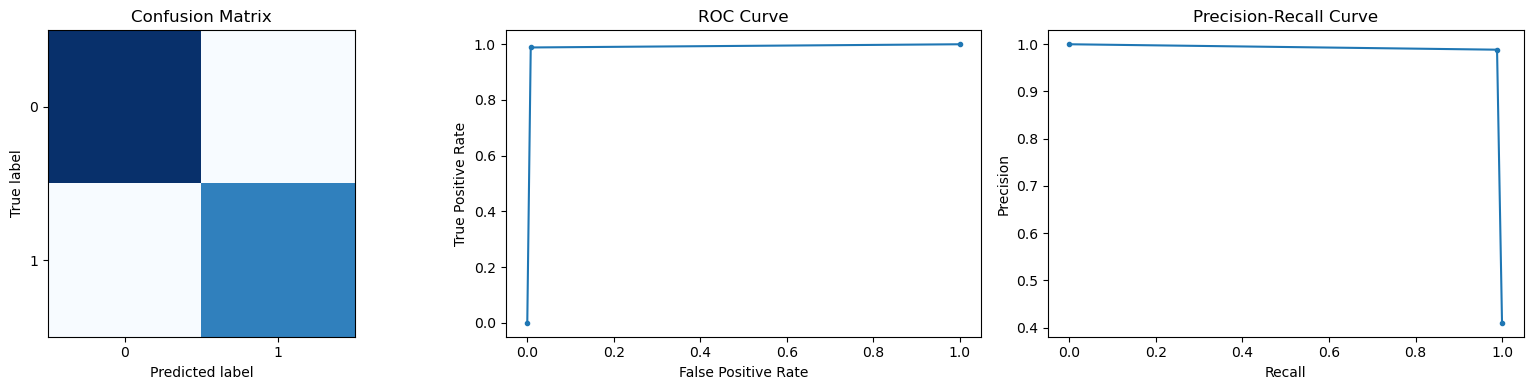

Accuracy: 0.9858490566037735 
Precision: 0.9770114942528736 
Recall: 0.9883720930232558 
F1 Score: 0.9826589595375722 
AUC: 0.98624953857512


c:\Users\alepo\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


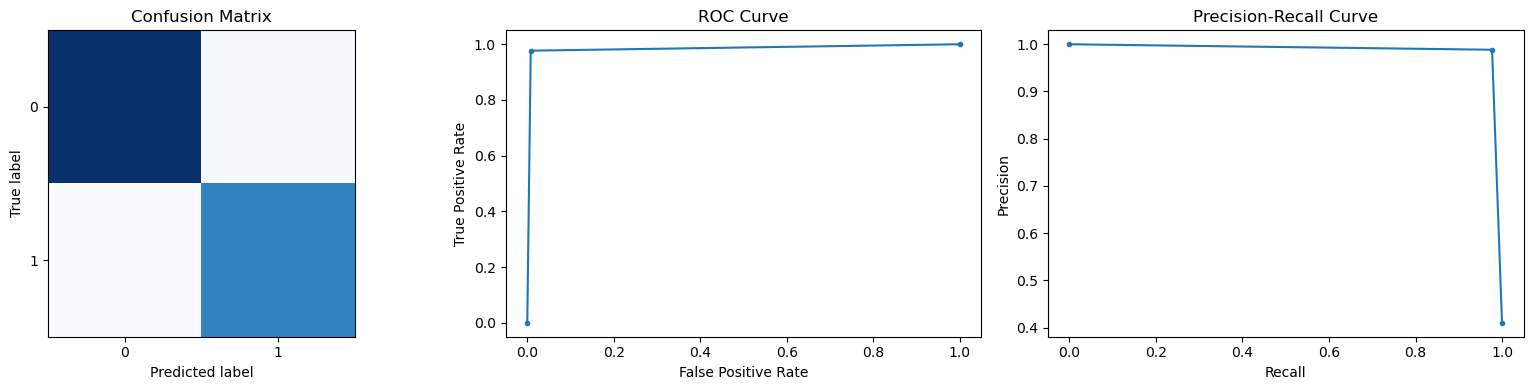

In [41]:
# Valutazione del modello Neural Network per la classificazione

# Il mio modello

model_params = {
    "mode": ["classification"],
    "layers": ["10-5"],
    "epochs": [200],
    "learning_rate": [0.01]
}

print("Metriche per la Neural Network")
optim_params["Neural Network"], classification_results["Neural Network"] = model_selection(MyNeuralNetwork, model_params, mode="classification", standardization=True)

# Il modello di sklearn

from sklearn.neural_network import MLPClassifier

hidden_layer_sizes = [eval(i) for i in optim_params["Neural Network"]["layers"].split("-")]
max_iter = optim_params["Neural Network"]["epochs"]
learning_rate = optim_params["Neural Network"]["learning_rate"]

model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, activation="logistic")
sklearn_results(model, "classification", standardization=True)

## Analisi e valutazione


In [42]:
# Analisi dei risultati ottenuti

regression_results_data = pd.DataFrame(regression_results).T
classification_results_data = pd.DataFrame(classification_results).T

In [43]:
print("Paramteri ottimali\n")
for model in optim_params:
    print(model, '\t', optim_params[model])

Paramteri ottimali

Linear Regression 	 {'mode': 'classification'}
Linear Regression GD 	 {'mode': 'classification', 'alpha': 0.1, 'lambda1': 0, 'lambda2': 0, 'num_iterations': 10000, 'cutoff': 0.0001, 'batch': 20}
Linear Regression SGD 	 {'mode': 'regression', 'alpha': 0.001, 'lambda1': 0, 'lambda2': 0, 'num_iterations': 10000, 'cutoff': 0.001, 'batch': 20}
Linear Regression GD Lasso 	 {'mode': 'regression', 'alpha': 0.0001, 'lambda1': 0.01, 'lambda2': 0, 'num_iterations': 10000, 'cutoff': 0.001}
Linear Regression GD Ridge 	 {'mode': 'regression', 'alpha': 0.0001, 'lambda1': 0, 'lambda2': 0.01, 'num_iterations': 10000, 'cutoff': 0.001}
Linear Regression GD Elastic Net 	 {'mode': 'regression', 'alpha': 0.0001, 'lambda1': 0.01, 'lambda2': 0.01, 'num_iterations': 10000, 'cutoff': 0.001}
Desicion Tree 	 {'h_max': 5}
Logistic Regression GD 	 {'lambda1': 0.1, 'lambda2': 0.1, 'alpha': 0.1, 'num_iterations': 10000, 'cutoff': 0.001, 'batch': 20}
Logistic Regression SGD 	 {'lambda1': 0, 'lambda

In [44]:
regression_results_data

,MSE,MAE,RMSE
Linear Regression,25.935008,4.013165,5.092643
Linear Regression GD,25.950069,4.013373,5.094121
Linear Regression SGD,26.844221,4.038699,5.181141
Linear Regression GD Lasso,25.950070,4.013375,5.094121
Linear Regression GD Ridge,25.950021,4.013389,5.094116
Linear Regression GD Elastic Net,25.950022,4.013391,5.094116
KNN Regression,34.485707,3.524616,5.872453
Neural Network Regression,8059.470771,85.913509,89.774555


In [45]:
classification_results_data

,Accuracy,Precision,Recall,F1 Score,\nAUC:
Linear Regression,0.976415,0.965517,0.976744,0.971098,0.976467
Linear Regression GD,0.962264,0.965517,0.943820,0.954545,0.959715
Desicion Tree,0.976415,0.965517,0.976744,0.971098,0.976467
Logistic Regression GD,0.981132,0.988506,0.966292,0.977273,0.979081
Logistic Regression SGD,0.966981,0.988506,0.934783,0.960894,0.963225
KNN Classification,0.990566,1.000000,0.977528,0.988636,0.988764
SVM,0.985849,0.988506,0.977273,0.982857,0.984604
Neural Network,0.990566,0.988506,0.988506,0.988506,0.990253


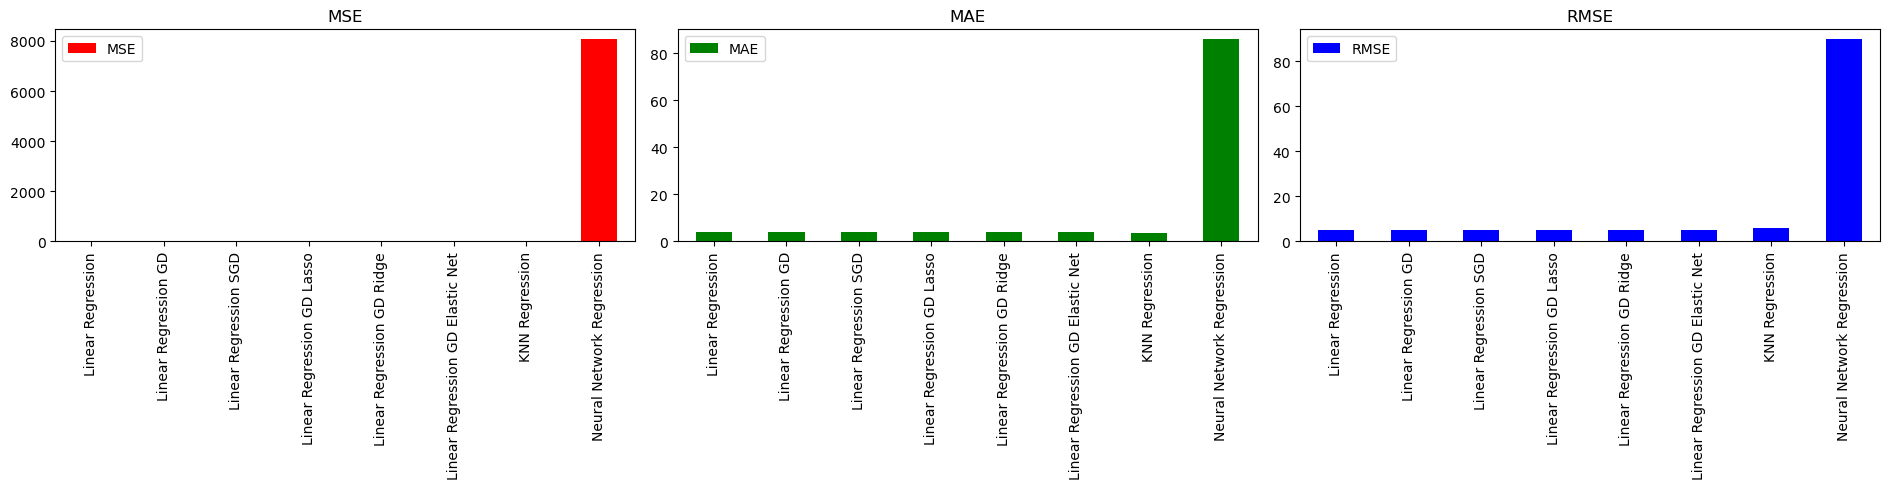

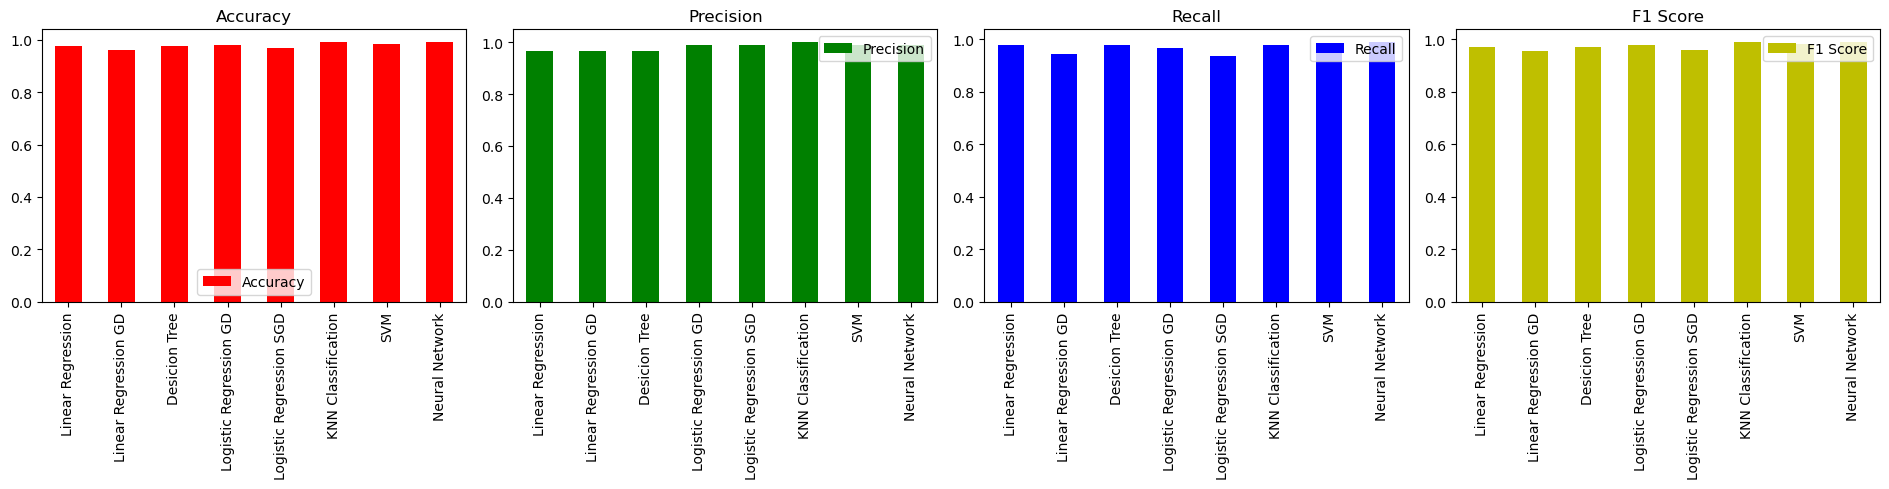

In [46]:
# Plot dei risultati della regressione e della classificazione

def plot_regression_results(regression_results_data,):  # Plotta i risultati della regressione con un bar plot orientato orizzontalmente
    fig, axs = plt.subplots(1, 3, figsize=(19, 5))

    regression_results_data.plot(kind="bar", y="MSE", ax=axs[0], color="r")
    axs[0].set_title("MSE")

    regression_results_data.plot(kind="bar", y="MAE", ax=axs[1], color="g")
    axs[1].set_title("MAE")

    regression_results_data.plot(kind="bar", y="RMSE", ax=axs[2], color="b")
    axs[2].set_title("RMSE")

    plt.tight_layout()
    plt.show()


def plot_classification_results(classification_results_data):
    fig, axs = plt.subplots(1, 4, figsize=(19, 5))

    classification_results_data.plot(kind="bar", y="Accuracy", ax=axs[0], color="r")
    axs[0].set_title("Accuracy")

    classification_results_data.plot(kind="bar", y="Precision", ax=axs[1], color="g")
    axs[1].set_title("Precision")

    classification_results_data.plot(kind="bar", y="Recall", ax=axs[2], color="b")
    axs[2].set_title("Recall")

    classification_results_data.plot(kind="bar", y="F1 Score", ax=axs[3], color="y")
    axs[3].set_title("F1 Score")

    plt.tight_layout()
    plt.show()


plot_regression_results(regression_results_data)
plot_classification_results(classification_results_data)